### DATA 620
### Project 2: 2-Mode Networks

__Team:__ Data Owls  
__Members:__ Keith Folsom, Valerie Briot
    
__Date:__ 10/12/2017
    
### Project Overview

This project is a continuation of the network analysis performed on the Yelp dataset for Project 1, which is located here: (https://github.com/kfolsom98/DATA620/blob/master/Project1/code/DataOwls_Project1_final.ipynb). However, unlike Project 1, the ensuing analysis will look at the Yelp dataset as a bimodal or 2-mode network of users and business.  

The businesses considered below are all restaurants in the Pittsburgh area with a review made during the 2014 and 2015 timeframe.  All Yelp users who have submitted a review of a Pittsburg restaurant during this timeframe will be included in this reduced 2-mode network.

### Background 

The Yelp Business Review dataset is located here https://www.yelp.com/dataset/download as a reference. 
Due to the volume of data in the current Yelp dataset, the 2015 Yelp Business Review dataset was be used given its smaller data volume.

The Yelp dataset is available in JSON or SQL format. Ultimately the JSON files noted below were used:

File  | Size
------|------------
business.json |	54 MB  
user.json |	158 MB  
review.json	| 1.32 GB  

Yelp is a crowd-sourced local business review and social networking site. Users can submit a review for products and services using a 1 to 5 start rating system.

For the purposes of this project, we will consider the Businesses and Users and bipartite nodes.  The business reviews created by users will provide the edgelist between the network nodes.

User-based reviews such as the Yelp dataset make for a natural bipartite graph for a 2-node type network with the two nodes being businesses and users.  The analysis below will examine businesses and users using the bipartite weighted projection method to study them as 1-mode networks.



### Data Preparation

Load the necessary Python packages and source the Pittsburg Business, Users, and Reviews.

In [2]:
import community
from community import community_louvain
import networkx as nx
import pandas as pd
import numpy as np
import math
import re                     
from itertools import count

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter


# set the default plot size
plt.rcParams['figure.figsize'] = (25, 15)

# hide warnings thrown from Python 2 to 3
import warnings
warnings.filterwarnings("ignore")


#### Import CSV files from GitHub

##### Pittsburgh Businesses

In [3]:
GitHub = "https://raw.githubusercontent.com/kfolsom98/DATA620/master/Project2/data/"

In [4]:
file = GitHub + "Businesses_Pittsburg.csv"
business = pd.read_csv(file,  header=0, encoding="latin-1")

## 1217 business
business.shape

(1217, 8)

In [3]:
business.head(5)

business_id                                               name  \
0  wqu7ILomIOPSduRwoWp4AQ                                            Denny's   
1  _jsJFrAmFVPRio0eEVExbA                                         McDonald's   
2  udZJ8YgsHdqtFDQkyPTV1Q                      Arby's Roast Beef Restaurants   
3  ZL6DNzyenFm9Kpz6uADlNg  Pino's Contemporary Italian Restaurant & Wine Bar   
4  OcTG-KzDleuRub-pb6JS3Q                                 Eddie's Pizza Haus   

                                        full_address  \
0          2180 Greentree Rd\r\nPittsburgh, PA 15220   
1  4557 Ohio River Blvd\r\nBellevue\r\nPittsburgh...   
2  4260 Ohio River Blvd\r\nBellevue\r\nPittsburgh...   
3  6738 Reynolds St\r\nPoint Breeze\r\nPittsburgh...   
4  1744 Chislett St\r\nMorningside\r\nPittsburgh,...   

                                          categories        city state  \
0  c("Breakfast & Brunch", "American (Traditional...  Pittsburgh    PA   
1           c("Burgers", "Fast Food", "Restaurants")  Pittsburgh    PA   
2                                        Restaurants  Pittsburgh    PA   
3  c("Tapas/Small Plates", "Restaurants", "Italian")  Pittsburgh    PA   
4                          c("Pizza", "Restaurants")  Pittsburgh    PA   

   review_count neighborhoods  
0             7  character(0)  
1             4      Bellevue  
2             3      Bellevue  
3            46  Point Breeze  
4             5   Morningside

#### Users Connected to Pittsburgh Business Reviews

In [5]:
file = GitHub + "Users_Pittsburg.csv"
user = pd.read_csv(file,  header=0, encoding="latin-1")

## 9189 business
user.shape

(9189, 6)

In [74]:
user.head(5)

user_id    name  average_stars  review_count  fans  \
0  RfBKeYFffFZ9qx6EcSzdaA    Phil           2.67             4     0   
1  VpsFsXYiVGmsBprr9Onb0Q  Amanda           4.00             7     0   
2  nVSpJQC1ULMKgiC8ItT6sQ  Robert           3.56            10     0   
3  G_BvSxt71MqF_x4jgEyqSA   Shari           4.34            97     7   
4  nuW7cTZhuSRupXeFbNMSRg     Joe           3.33             6     0   

  yelping_since  
0       2013-10  
1       2014-01  
2       2014-05  
3       2008-11  
4       2011-01

##### Reviews of the Pittsburgh Restaurants 

In [4]:
file = GitHub + "Reviews_Pittsburg.csv"
review = pd.read_csv(file,  header=0)

## 23339 non-distinct reviews  by user_id, business_id
review.shape

# drop the stars (rating) column
review.drop(review.columns[2],axis=1,inplace=True)

# deduplicate 
review = review.drop_duplicates()

## 22934 distinct reviews
review.shape

(22934, 2)

In [7]:
review.head(5)

user_id             business_id
0  CiCmxCruMvbXtjQP5FhbLg  wqu7ILomIOPSduRwoWp4AQ
1  bbYn77XD_aAeFL-lwV7GBA  wqu7ILomIOPSduRwoWp4AQ
2  UxfFAw2-cTpeWvRROF1HEw  wqu7ILomIOPSduRwoWp4AQ
3  3eystYBQINAG1tlRBk215A  wqu7ILomIOPSduRwoWp4AQ
4  vQPRddwB2m9se3GDM05eGw  _jsJFrAmFVPRio0eEVExbA

#### Created a Bipartite Graph of Bussinesses and Users

In [8]:

G = nx.Graph()

# Create the business nodes with attributes - name, categories, and neighborhoods.
for index, row in business.iterrows():
    # print(row['business_id'])
    G.add_node(row['business_id'],
               bipartite=0,
               name=row['name'],
               categories=row['categories'],
               neighborhoods=row['neighborhoods'])
             

# Create the user nodes with attributes - name, categories, and neighborhoods.  
# Categories and neighborhoods are null for users but included for node attribute consistency 
# between businesses and users
for index, row in user.iterrows():
    # print(row['business_id'])
    G.add_node(row['user_id'],
               bipartite=1,
               name=row['name'],
               categories=None,
               neighborhoods=None)

# edges
G.add_edges_from([(row['business_id'], row['user_id']) for idx, row in review.iterrows()])

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10405
Number of edges: 22934
Average degree:   4.4083


We see the Yelp business and user bipartite network has 10,405 nodes with 22,934 edges.  Let's check some network characteristics:

In [9]:
print("Bipartite Network G\n  Bipartite: {}\n  Connected: {}".format(nx.is_bipartite(G), 
                                                                 nx.is_connected(G)))

Bipartite Network G
  Bipartite: True
  Connected: False


Since the network has some unconnected subgraphs, we'll remove these and work on the largest connected subgraph.  The subgraphs being removed all have 5 or less nodes.  This takes the overall nodes down from 10,405 to 10,192.

In [10]:
subgraphs = nx.connected_component_subgraphs(G)

Gsub = max(nx.connected_component_subgraphs(G), key=len)

print(nx.info(Gsub))

Name: 
Type: Graph
Number of nodes: 10192
Number of edges: 22891
Average degree:   4.4920


Calculate the network density.  This is a fairly resource-intensive calculation for this size network. Once the shortest path length from every node to all other nodes is calculated, the diameter is the longest of all the calculated path lengths. The diameter is representative of the linear size of a network.

In [17]:
print('Network diameter =', nx.diameter(Gsub))

In [ ]:
The network diameter is 10.

### Create Bipartite Node Sets for Users and Businesses


In [11]:
users, businesses = nx.bipartite.sets(Gsub)

len(users), len(businesses)

(9146, 1046)

In [80]:
# let's check the density of the user nodes
nx.bipartite.density(Gsub, users)

0.002392775117396607

It's interesting to note here that the user network is not particularly dense.  This will be explored more below.

### Create the weighted projected graph of User and Businesses.

In [12]:
U = nx.bipartite.weighted_projected_graph(Gsub, users, ratio=False)

In [13]:
B = nx.bipartite.weighted_projected_graph(G, businesses, ratio=False)

Let's look at the resulting weighted projected graph of users.

In [14]:
print(nx.info(U))

Name: 
Type: Graph
Number of nodes: 9146
Number of edges: 696786
Average degree: 152.3696


In [15]:
triadic_closure = nx.transitivity(U)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.33138271140390124


Again, looking at the transitivity value of the User network U, we see a value lower than might be expected given that there is a finite number of restaurants in Pittsburgh being reviewed.  As a ratio, it's roughly 1 business for every 9 users.

In [16]:
# Business projected graph information
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 1046
Number of edges: 85125
Average degree: 162.7629


## Communities Within  the User Nodes

To understand what the weighted projected user network looks like, let's examine the communities within the network.  Communities are identified using the Louvain detection method.  Generally, commmunities are nodes within the network that are more densely connected to each other than other nodes, or the concept of modularity.

In [17]:
partitions = community_louvain.best_partition(U)

In [18]:
set(partitions.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

There are over 10 different communities within the user network. Known as modularity, this provides a sense of how fractured the network is.

Let's plot the communities.  Again an intensive operation but an interesting visual of the communities within the user network.  We see some very distinct communities in the graph below but will need to trim the network to develop a better understanding.

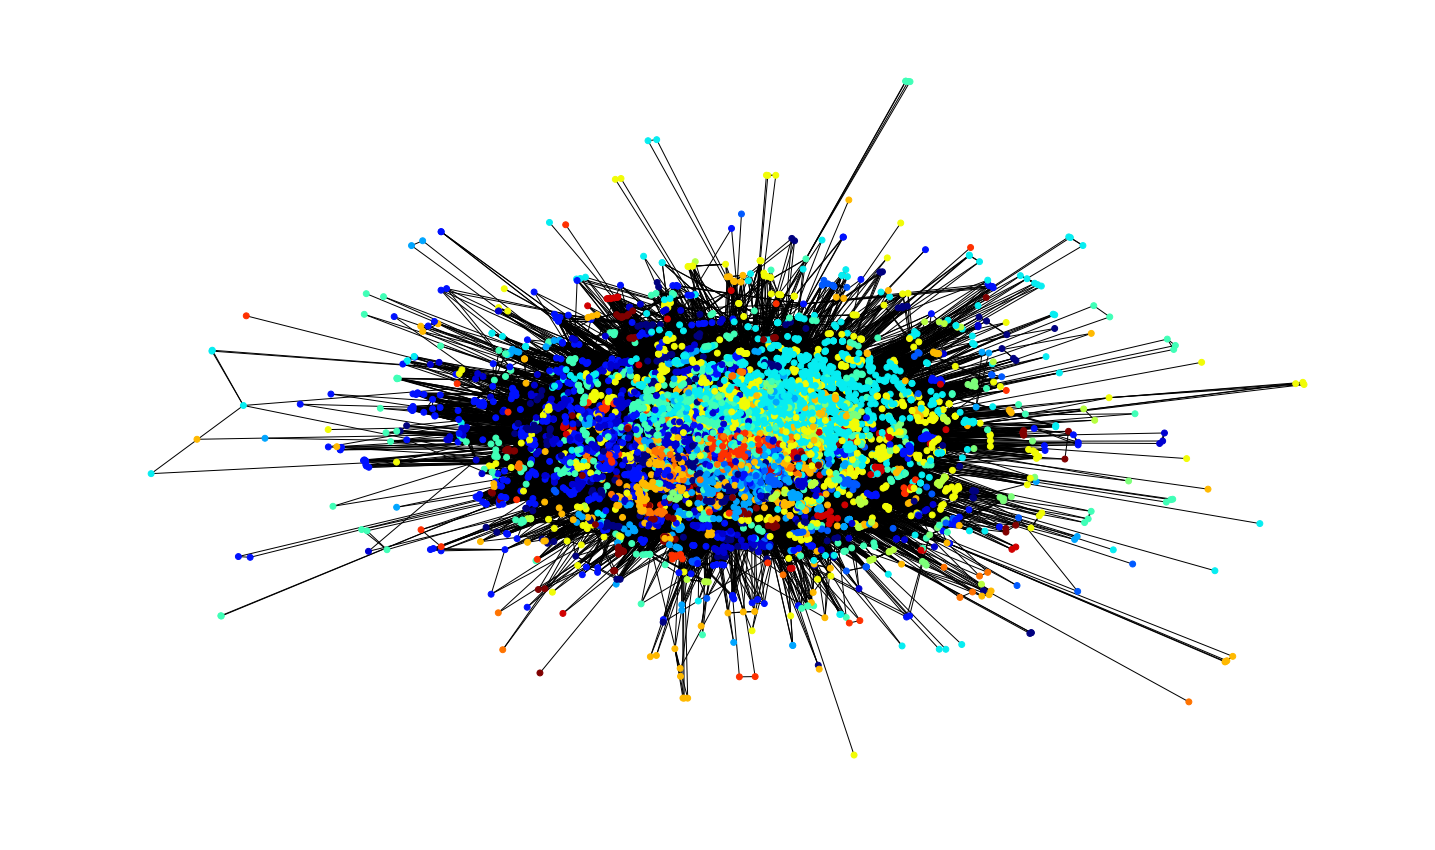

In [39]:
values = [partitions.get(node) for node in U.nodes()]
spring_pos = nx.spring_layout(U)
plt.axis("off")
nx.draw_networkx(U, pos = spring_pos, 
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = 35, with_labels = False)

In [19]:
# Assign the partition (modularity score) to the user nodes for later use
nx.set_node_attributes(U, 'partition', partitions)

In [20]:
partitions_df = pd.DataFrame({'partition':partitions})

#### Distribution of Users Within Communities

In [23]:

# function to generate histogram

def plot_dist(df, range, bins):

    # Plot the distribution of users within each community
    sns.set_style("whitegrid")    # Set style for seaborn output
    sns.set_context("notebook", font_scale=1.5)
    plt.figure(figsize=(8,8))
    plt.xticks(range)  s
    plt.xlabel("Partition")
    plt.ylabel("Frequency")
    plt.title("Distribution of Users Within Communities", fontsize=16)

    sns.distplot(partitions_df, bins=bins, kde=False, rug=False);
    

Plot the distribution on user nodes by partition as seen below.  One partition in particular, 6, has the most users nodes.

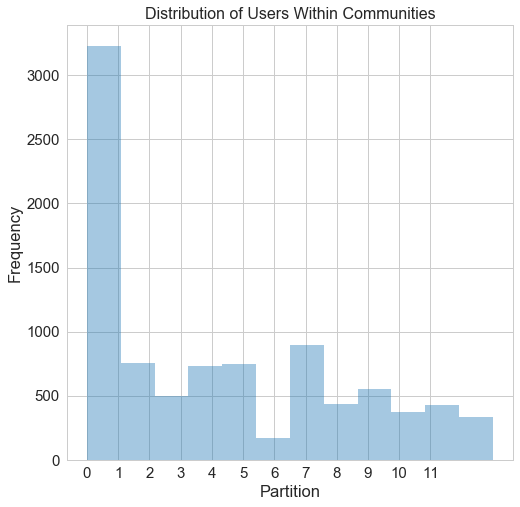

In [24]:
plot_dist(partitions_df, np.arange(0,12,1), 12);

In [25]:
partitions_df['partition'].value_counts()

1     2533
7      896
2      759
5      747
4      729
0      698
9      554
3      495
8      434
11     424
10     370
12     307
6      172
13      28
Name: partition, dtype: int64

### Trim the User Network Using the Island Method

Apply the Island Method to the user network given the large number of nodes.  

In [26]:
# Trim edges function is taken directly from SNABook

def trim_edges(g, weight=1):
    """
    Remove edges with weights less then a threshold parameter ("weight")
    """
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
     
    return g2
            

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

Apply the Island Method to determine the minimim water level for trimming the network.  Below, we're using a minimum weight between user nodes of 4 (where weight is greater than 3).  We've picked 4 as the minimum to retain a workable portion of user nodes.

In [ ]:
## Apply Island Analysis on the user nodes
cc = list(nx.connected_component_subgraphs(U))[0]
islands = island_method(cc, 3)

In [215]:
print ('Weight  Users  Groups')
for i in islands:
   print('{}       {}       {}'.format(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))

Weight  Users  Groups
1       2685       2
12       44       2
23       9       1
34       2       1


In [31]:
# apply a minimum weight 3 water level and create the trimmed user subgraph
Usub = trim_edges(U, 3)

In [32]:
print(nx.info(Usub))

Name: 
Type: Graph
Number of nodes: 601
Number of edges: 5562
Average degree:  18.5092


#### Recalculate Communities following the network trimming.

In [33]:
partitions = community_louvain.best_partition(Usub)
set(partitions.values())

{0, 1, 2, 3, 4, 5}

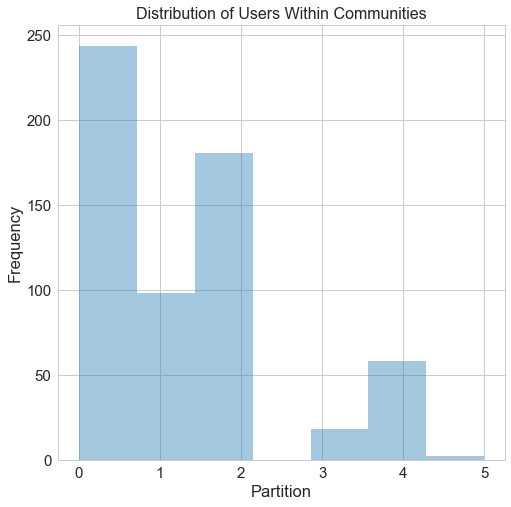

In [34]:
partitions_df = pd.DataFrame({'partition':partitions})
plot_dist(partitions_df, np.arange(0,6,1), 7);

#### Note above that largest community paritition from the original histogram has dropped significantly after networking trimming, indicating that many of the nodes had an edge weight less than 3.

### Calculate Centrality Measures and Save them on the User node

In [36]:
deg = nx.degree_centrality(Usub)                       # Run degree centrality         

In [40]:
bet = nx.betweenness_centrality(Usub)                  # Run betweenness centrality

In [39]:
eig = nx.eigenvector_centrality(Usub)                  # Run eigenvector centrality

In [41]:
clos = nx.closeness_centrality(Usub) 

In [42]:
# Assign each to an attribute in your network
nx.set_node_attributes(Usub, 'degree', deg)
nx.set_node_attributes(Usub, 'eigenvector', eig)
nx.set_node_attributes(Usub, 'betweenness', bet)
nx.set_node_attributes(Usub, 'closeness', clos)
nx.set_node_attributes(Usub, 'partition', partitions)

In [50]:
# Create a Usub dataframe with the node ID and metrics

# first assign the username to the Usub network
for n in Usub.nodes():
    #apply the name from G as an attribute of sub_G
    Usub.node[n]['name'] = G.node[n]['name'] 


In [53]:
graph = Usub.nodes(data = True)

data={}

data['node'] = [x[0] for x in graph]
data['name'] =[x[1]['name'] for x in graph]
data['degree'] = [x[1]['degree'] for x in graph]
data['eigenvector'] = [x[1]['eigenvector'] for x in graph]
data['betweenness'] = [x[1]['betweenness'] for x in graph]
data['closeness'] = [x[1]['closeness'] for x in graph]
data['partition'] = [x[1]['partition'] for x in graph]

# load into a data frame
usub_df = pd.DataFrame(data)
usub_df = usub_df.set_index(['node'])


#### Who are the most important users based on eigenvector centrality?

In [56]:
usub_df.sort_values(by=['eigenvector'], ascending=[0]).head(10)

betweenness  closeness    degree  eigenvector  \
node                                                                    
9OZH1Ecw-qUkCW5MS0NefA     0.191210   0.669643  0.508333     0.271502   
UnGPr6ZnGe9YOSZRopnS5g     0.103585   0.606673  0.365000     0.203992   
q4_kY8bBeigYPVS0Ak7QGg     0.076966   0.598802  0.341667     0.187603   
SlKJNLm1SQdgaaKtqD--1w     0.062811   0.587084  0.306667     0.184597   
nEYPahVwXGD2Pjvgkm7QqQ     0.060108   0.585938  0.313333     0.181443   
o9XGClSBzCsQxbcCzTPdnQ     0.045037   0.582524  0.296667     0.178876   
kWkgwRxqWD-h260dMTkHUA     0.041658   0.584795  0.306667     0.178713   
59A-ZxUMOgIl2MAnySh-Aw     0.048693   0.573614  0.273333     0.176259   
J_q8jN623uew8ZzMChXBCA     0.049239   0.583090  0.303333     0.175975   
wCJbSEmMeZ0mAnJRQEyfCQ     0.026154   0.569260  0.258333     0.170331   

                             name  partition  
node                                          
9OZH1Ecw-qUkCW5MS0NefA      Laura          0  
UnGPr6ZnGe9YOSZRopnS5g       Anne          0  
q4_kY8bBeigYPVS0Ak7QGg      Shawn          2  
SlKJNLm1SQdgaaKtqD--1w  MaryAlice          0  
nEYPahVwXGD2Pjvgkm7QqQ     Rachel          2  
o9XGClSBzCsQxbcCzTPdnQ      Carly          4  
kWkgwRxqWD-h260dMTkHUA      Jason          2  
59A-ZxUMOgIl2MAnySh-Aw     Joseph          0  
J_q8jN623uew8ZzMChXBCA      David          2  
wCJbSEmMeZ0mAnJRQEyfCQ     Lauren          0

### Examination of Important Users Across Communities

Let's redraw the User subgraph now that the number of nodes has been reduced.

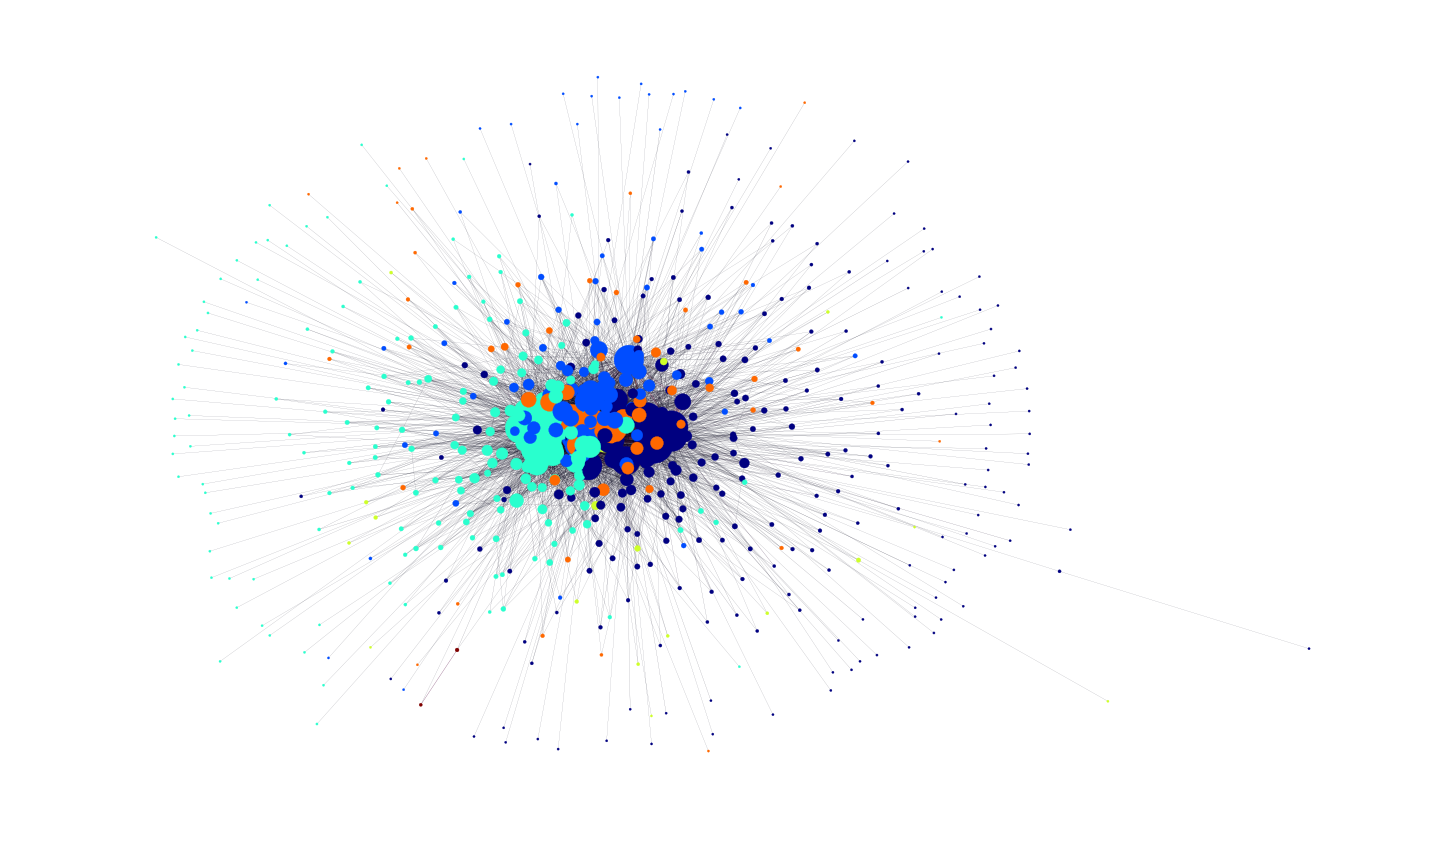

In [204]:
plt.axis("off")

values = [partitions.get(node) for node in Usub.nodes()]
weights = [edata['weight']/50 for f,t,edata in Usub.edges(data=True)]
spring_pos = nx.spring_layout(Usub)
ns = [v*5 for v in Usub.degree().values()]

nx.draw_networkx(Usub, pos = spring_pos,   width=weights, edge_color=weights,
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = ns, with_labels = False)

Let's focus on the key users within each community, using eigenvector centrality as a measure of importance.  Reviewing the existing communities in the user subgraph.

In [122]:
set(partitions.values())

{0, 1, 2, 3, 4, 5, 6}

In [205]:
# function to return the top n users within each community based on ev centrality

def get_top_users_by_community(g, partitions, top=3):
    lst = []
    
    for i, n in enumerate(partitions):
    
        # First get a list of just the nodes in that class
        class_nodes = [n for n in g.nodes() if g.node[n]['partition'] == i]

        # Then create a dictionary of the eigenvector centralities of those nodes
        class_eigenvector = {n:g.node[n]['eigenvector'] for n in class_nodes}

        # Then sort that dictionary and print the first 5 results
        class_sorted_by_eigenvector = sorted(class_eigenvector.items(), key=itemgetter(1), reverse=True)

        #print("Parition {} Sorted by Eigenvector Centrality:".format(i))
        for node in class_sorted_by_eigenvector[:top]:
         #  print("Name:", node[0], "| Eigenvector Centrality:", node[1])
           lst.append([i, node[0], node[1]])
    
    return lst
    

In [206]:
top = get_top_users_by_community(Usub, set(partitions.values()), 1)

top_df = pd.DataFrame.from_dict(top)
top_df.columns =['partition', 'user_id', 'eigenvector']
top_df = top_df.set_index(['user_id'])


In [207]:
# merge the user dataframe and the sampled metrics dataframe
top_df = pd.merge(usub_df, top_df,right_index=True, left_index=True)

In [208]:
top_df.iloc[:,:6].sort_values(by='partition_x', ascending=1)

betweenness  closeness    degree  eigenvector_x  \
9OZH1Ecw-qUkCW5MS0NefA     0.191210   0.669643  0.508333       0.271502   
tH4brXlghqKn_9GbahrMTQ     0.065885   0.578592  0.291667       0.146805   
q4_kY8bBeigYPVS0Ak7QGg     0.076966   0.598802  0.341667       0.187603   
0P58MD0FRVI6pTVKUpd7YA     0.045055   0.580271  0.285000       0.169033   
o9XGClSBzCsQxbcCzTPdnQ     0.045037   0.582524  0.296667       0.178876   
LiVXtHxGX6TjNHsBWeb9KA     0.000065   0.375469  0.005000       0.002572   

                           name  partition_x  
9OZH1Ecw-qUkCW5MS0NefA    Laura            0  
tH4brXlghqKn_9GbahrMTQ  Jocelyn            1  
q4_kY8bBeigYPVS0Ak7QGg    Shawn            2  
0P58MD0FRVI6pTVKUpd7YA  Rebecca            3  
o9XGClSBzCsQxbcCzTPdnQ    Carly            4  
LiVXtHxGX6TjNHsBWeb9KA   Justin            5

#### Let's draw the the graph of the businesses the top users in each community are connected to through ratings.

In [ ]:
# create a function to find all the neighbors of a given user node.  In this case the neighbors will be
# businesses from the bipartite graph.
def create_subgraph(subgraph, start_node):
        
    for n in G.neighbors_iter(start_node):
        subgraph.add_path([start_node,n])
   
    return subgraph

In [80]:
# create a subgraph of the top users by community.  This process takes each user and find his/her business 
# neigbhors in the bipartite graph G

df = pd.DataFrame.from_dict(top)
df.columns =['partition', 'user_id', 'eigenvector']

#df[df.partition==0]

sub_G = nx.Graph()

for index, row in df.iterrows(): 
    create_subgraph(sub_G, row['user_id'])
   

for n in sub_G.nodes():
    #apply the name from G as an attribute of sub_G
    sub_G.node[n]['name'] = G.node[n]['name']
    sub_G.node[n]['neighborhoods'] = G.node[n]['neighborhoods']
    

### Top Community Users - Businesses Graph

In [263]:

def draw_network(users, font_size, font_color):

    colors=[]
    labels=[]
    sub = nx.Graph()

   
    

    for i in users: 
      create_subgraph(sub, i)
   
    for n in sub.nodes():
        #apply the name from G as an attribute of sub_G
        sub.node[n]['name'] = G.node[n]['name']
        sub.node[n]['neighborhoods'] = G.node[n]['neighborhoods']
    

    labels = nx.get_node_attributes(sub, "name")

    for n, d in sub.nodes(data=True):
        if n in users:
            colors.append('r')
        else:
            colors.append('b')
            
    spring_pos = nx.spring_layout(sub)

    ns = [v*25 for v in sub.degree().values()]

    plt.figure(figsize=(20,15))

    nx.draw(sub, pos=spring_pos,
            with_labels=False, 
            edge_color='black', 
            node_color=colors, 
            vmin=1.0, vmax=5.0, 
            alpha=.5,  
            node_size=ns) 

    nx.draw_networkx_labels(sub, spring_pos, labels, font_size=font_size, font_color=font_color)
    
    plt.show()  
    
    

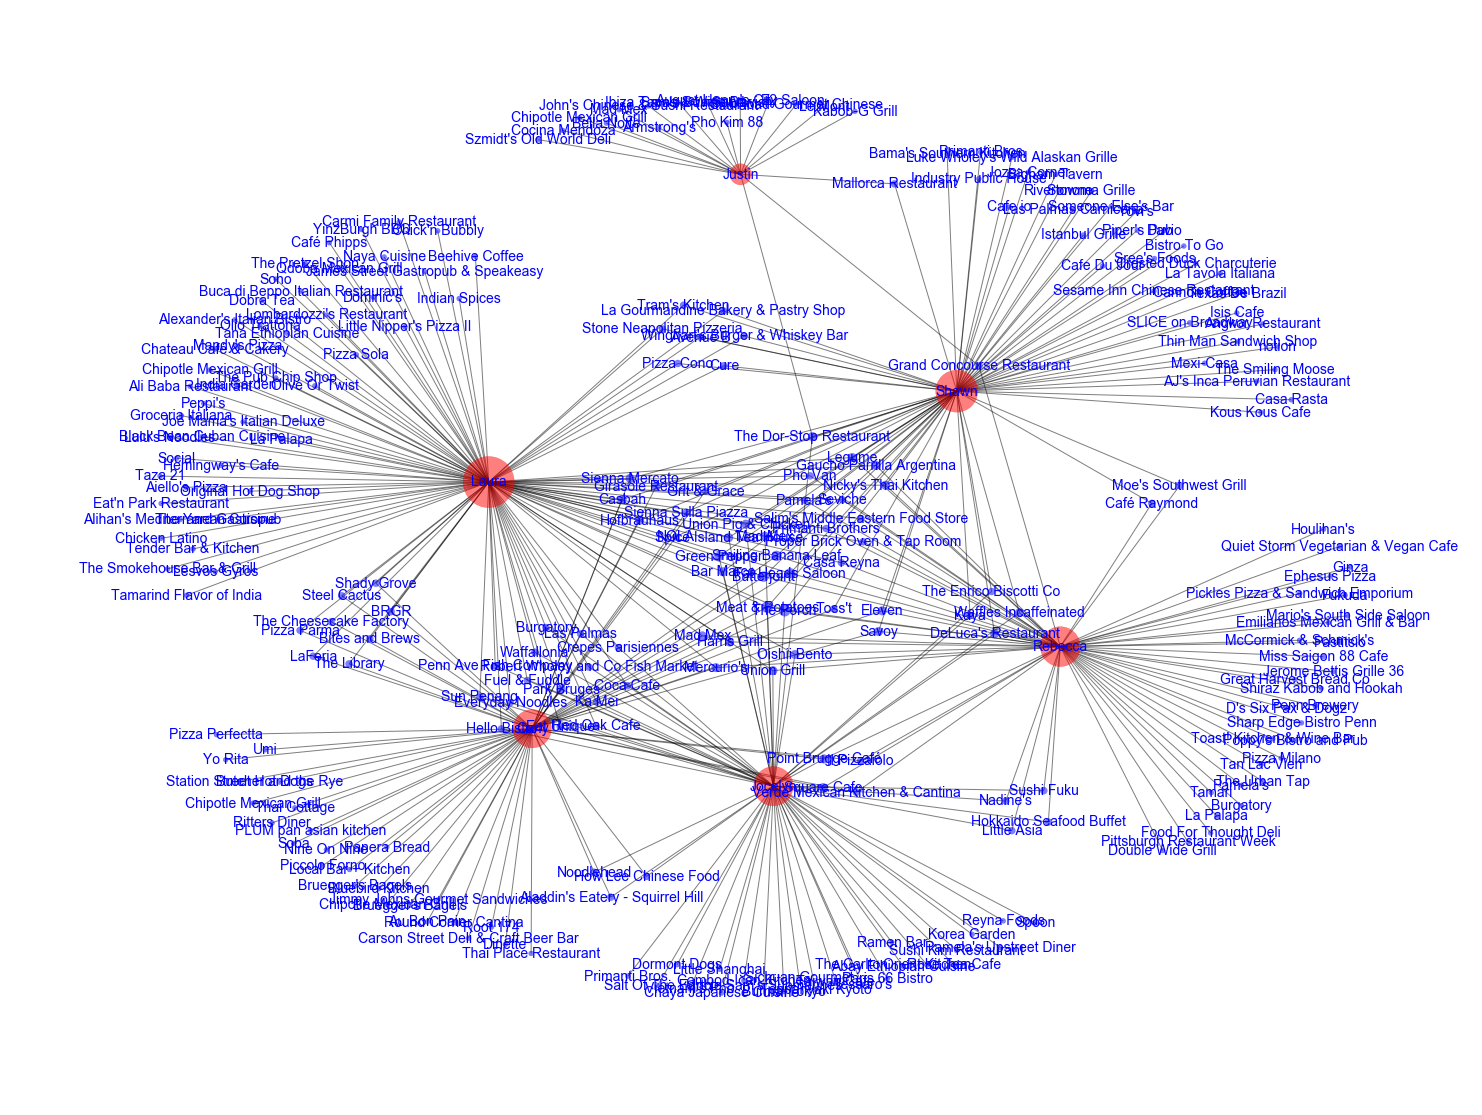

In [278]:
## Top user by community subgraph
draw_network(df['user_id'].values.tolist(), 14, 'blue')

One immediate takeaway from the graph above is that there the amount of overlap in common business reviews is surprisingly lower than one might expect.  This seems counter to intuition that there would be higher similarity among users and the businesses they're reviewing.

### User Similarity

Let's examine similarity between users to better understand what we're seeing above.  Similarity will be calculated using the Jaccard Similarity method which is defined as Intersection(A, B) / Union(A, B).

In [88]:
import itertools
list(itertools.combinations(df.user_id, 2))

# create the combinations of the top users for similarity scoring
top_users = pd.DataFrame(list(itertools.combinations(df.user_id, 2)), columns=['user1', 'user2'])

top_users['user1_nodes']= np.nan
top_users['user2_nodes']= np.nan
top_users['common_nodes']= np.nan
top_users['total_nodes']= np.nan
top_users['similarity']= np.nan


Calculate Similarity scores among the top community users.

In [93]:
for index, row in top_users.iterrows():
    n1 = set(G.neighbors(row['user1'])) #find the business neighbors of user1
    n2 = set(G.neighbors(row['user2'])) #find the business neighbors of user1
    
    top_users.loc[index, 'user1_nodes'] = len(n1)
    top_users.loc[index, 'user2_nodes'] = len(n2)
    top_users.loc[index, 'common_nodes'] = len(set(n1).intersection(n2))
    top_users.loc[index, 'total_nodes'] = len(set(n1).union(n2))
    
    # calculate similarity using Jaccard Similarity
    # = Intersection(A, B) / Union(A, B)
    top_users.loc[index, 'similarity'] = row['common_nodes']/row['total_nodes']

In [94]:
top_users.sort_values(by='similarity', ascending=0)

user1                   user2  common_nodes  total_nodes  \
0   9OZH1Ecw-qUkCW5MS0NefA  tH4brXlghqKn_9GbahrMTQ          24.0        143.0   
1   9OZH1Ecw-qUkCW5MS0NefA  q4_kY8bBeigYPVS0Ak7QGg          24.0        152.0   
3   9OZH1Ecw-qUkCW5MS0NefA  o9XGClSBzCsQxbcCzTPdnQ          21.0        143.0   
2   9OZH1Ecw-qUkCW5MS0NefA  0P58MD0FRVI6pTVKUpd7YA          20.0        149.0   
10  q4_kY8bBeigYPVS0Ak7QGg  o9XGClSBzCsQxbcCzTPdnQ          15.0        115.0   
12  0P58MD0FRVI6pTVKUpd7YA  o9XGClSBzCsQxbcCzTPdnQ          14.0        109.0   
9   q4_kY8bBeigYPVS0Ak7QGg  0P58MD0FRVI6pTVKUpd7YA          14.0        121.0   
6   tH4brXlghqKn_9GbahrMTQ  0P58MD0FRVI6pTVKUpd7YA          12.0        114.0   
5   tH4brXlghqKn_9GbahrMTQ  q4_kY8bBeigYPVS0Ak7QGg          12.0        121.0   
7   tH4brXlghqKn_9GbahrMTQ  o9XGClSBzCsQxbcCzTPdnQ           8.0        113.0   
11  q4_kY8bBeigYPVS0Ak7QGg  LiVXtHxGX6TjNHsBWeb9KA           2.0         87.0   
8   tH4brXlghqKn_9GbahrMTQ  LiVXtHxGX6TjNHsBWeb9KA           1.0         79.0   
13  0P58MD0FRVI6pTVKUpd7YA  LiVXtHxGX6TjNHsBWeb9KA           1.0         81.0   
4   9OZH1Ecw-qUkCW5MS0NefA  LiVXtHxGX6TjNHsBWeb9KA           0.0        123.0   
14  o9XGClSBzCsQxbcCzTPdnQ  LiVXtHxGX6TjNHsBWeb9KA           0.0         77.0   

    similarity  user1_nodes  user2_nodes  
0     0.167832        105.0         62.0  
1     0.157895        105.0         71.0  
3     0.146853        105.0         59.0  
2     0.134228        105.0         64.0  
10    0.130435         71.0         59.0  
12    0.128440         64.0         59.0  
9     0.115702         71.0         64.0  
6     0.105263         62.0         64.0  
5     0.099174         62.0         71.0  
7     0.070796         62.0         59.0  
11    0.022989         71.0         18.0  
8     0.012658         62.0         18.0  
13    0.012346         64.0         18.0  
4     0.000000        105.0         18.0  
14    0.000000         59.0         18.0

__Looking at the similarity scores above, we can see that the top users across the communities with low similarity scores.__

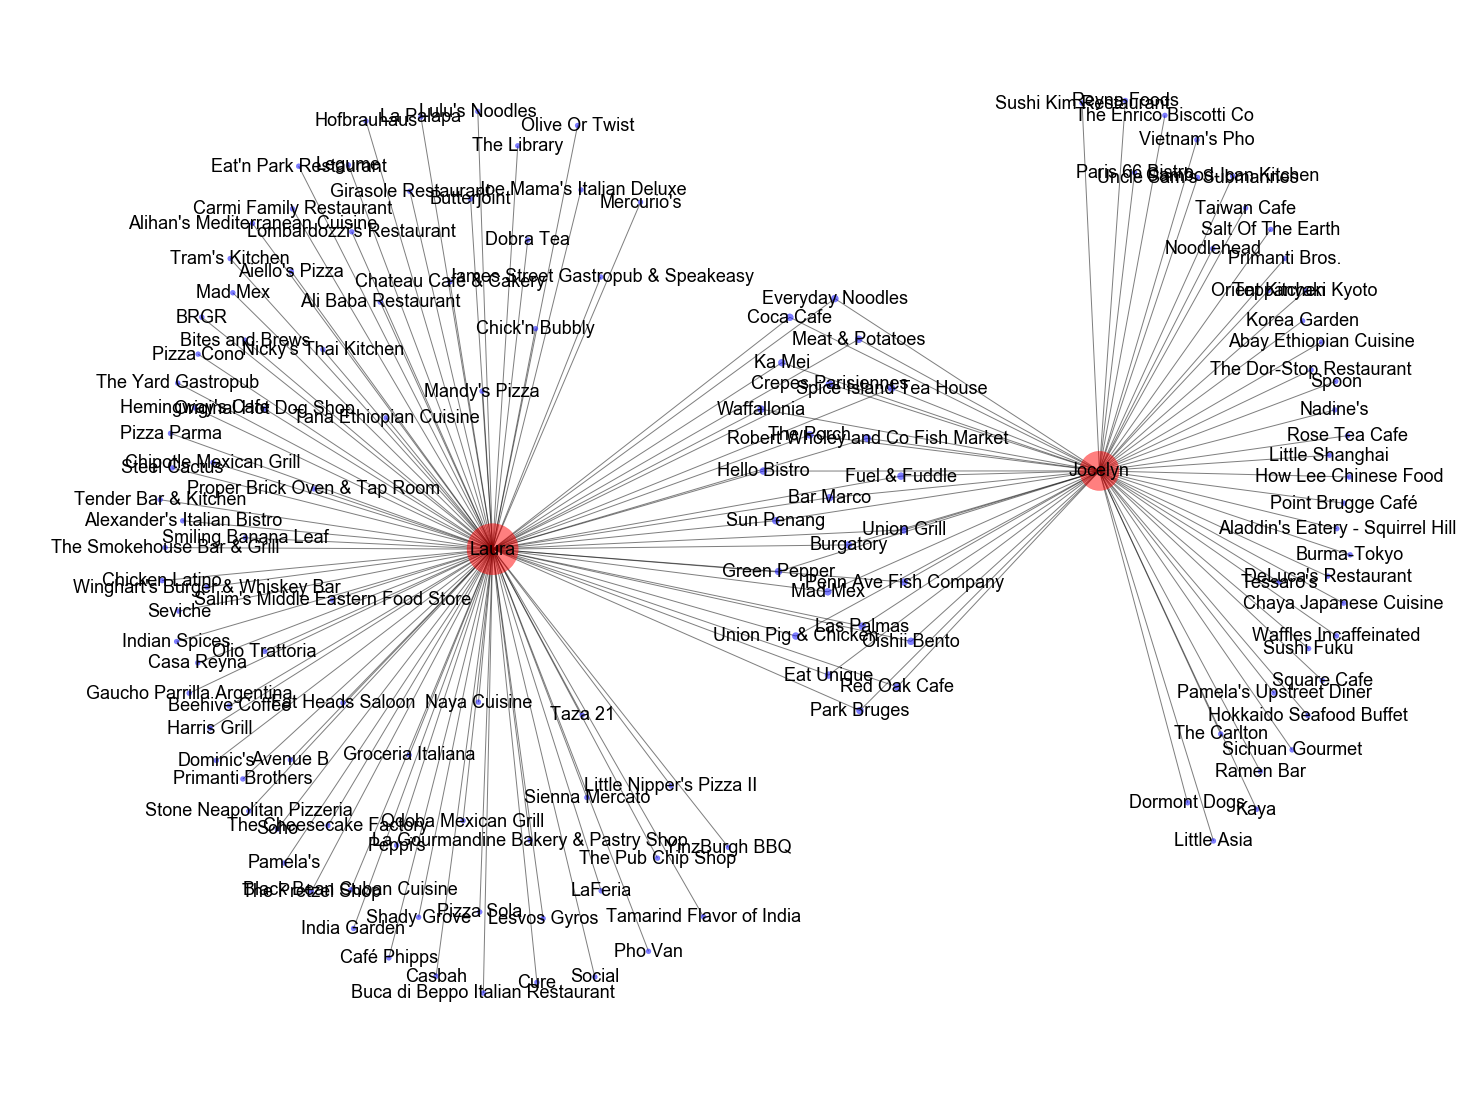

In [267]:
# network graph of the two most similar users among the communities
draw_network(['9OZH1Ecw-qUkCW5MS0NefA', 'tH4brXlghqKn_9GbahrMTQ'], 18, 'black')

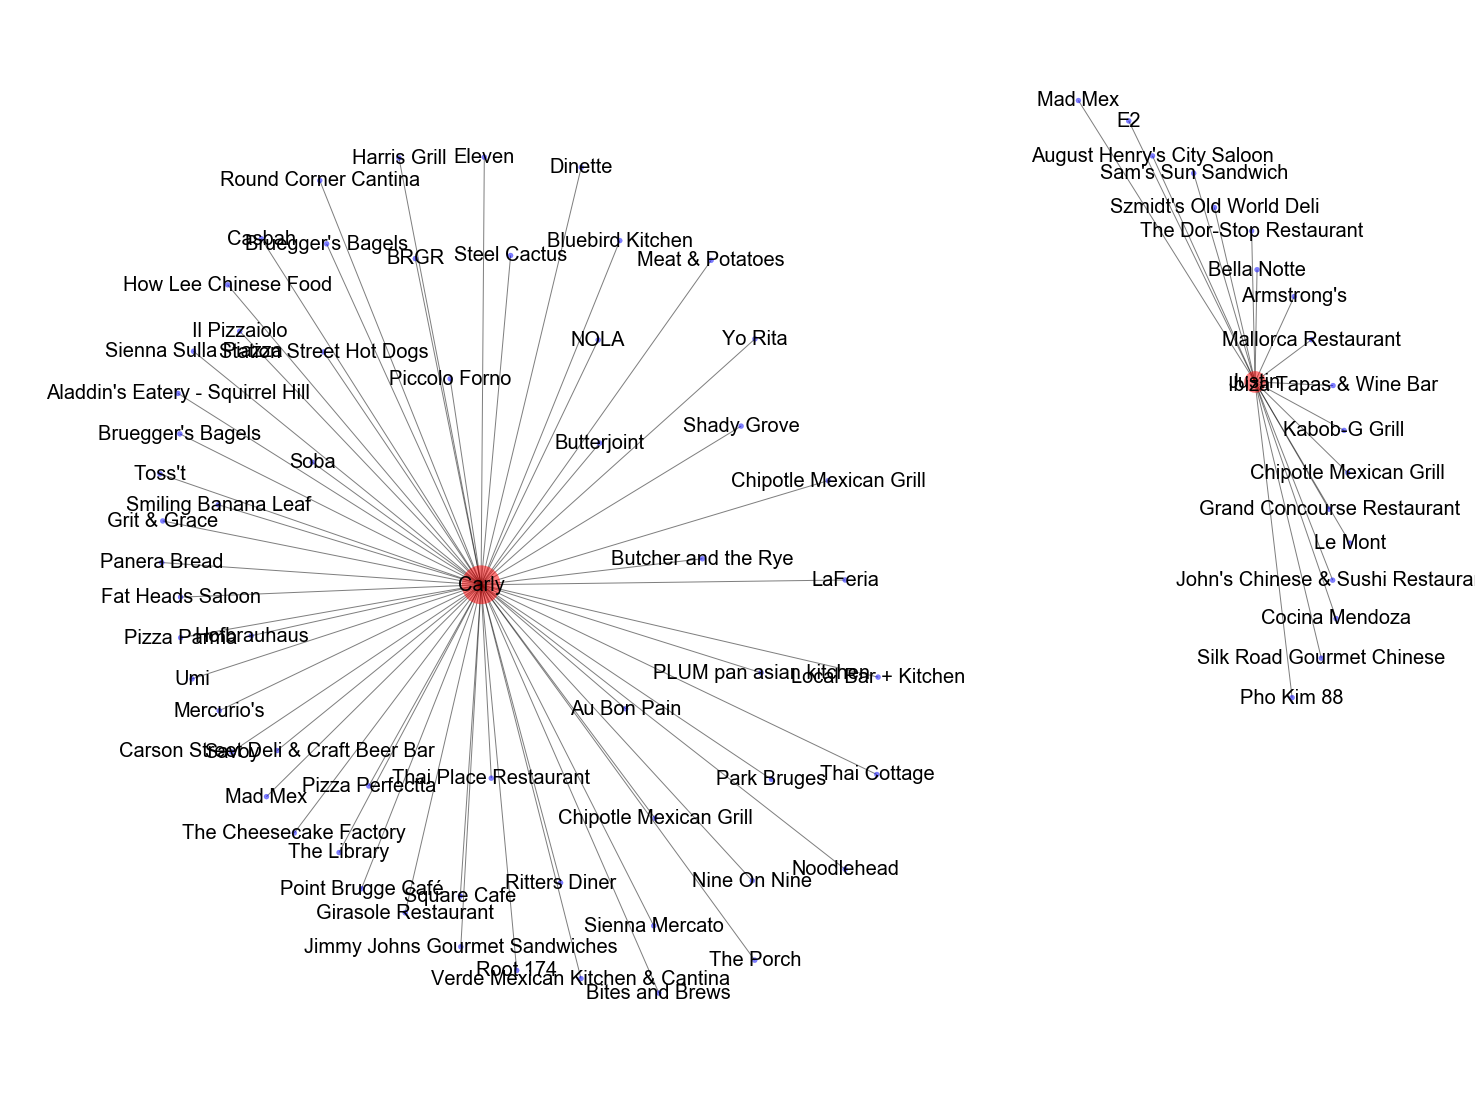

In [260]:
# network graph of the two most dissimilar users among the communities
draw_network(['o9XGClSBzCsQxbcCzTPdnQ', 'LiVXtHxGX6TjNHsBWeb9KA'], 20, 'black')

#### Does this similarity hold true for the larger user subgraph?  Let's randomly sample some users from the subgraph and apply a the same approach for similarity.

In [95]:
import random

# randomly sample 100 users within the network
random_nodes = random.sample(Usub.nodes(), 100)

usub_nodes_list = list(itertools.combinations(random_nodes, 2))

all_users = pd.DataFrame(usub_nodes_list, columns=['user1', 'user2'])
   
all_users['user1_nodes']= np.nan
all_users['user2_nodes']= np.nan    
all_users['common_nodes']= np.nan
all_users['total_nodes']= np.nan
all_users['similarity']= np.nan
all_users.shape


(4950, 5)

#### Calculate Similarity for the randomly sampled users

In [101]:
for index, row in all_users.iterrows():
    n1 = set(G.neighbors(row['user1'])) #find the business neighbors of user1
    n2 = set(G.neighbors(row['user2'])) #find the business neighbors of user1
    
    all_users.loc[index, 'user1_nodes'] = len(n1)
    all_users.loc[index, 'user2_nodes'] = len(n2)
    all_users.loc[index, 'common_nodes'] = len(set(n1).intersection(n2))
    all_users.loc[index, 'total_nodes'] = len(set(n1).union(n2))
    
    # calculate similarity using Jaccard Similarity
    # = Intersection(A, B) / Union(A, B)
    all_users.loc[index, 'similarity'] = row['common_nodes']/row['total_nodes']


In [102]:
all_users.sort_values(by='similarity', ascending=0).head(10)

user1                   user2  common_nodes  \
4388  XUXMBPMvlzjcCdzTaOmtjg  iaN3YatnCHZkYuPda0Z-XQ           2.0   
4254  ZQM9jRu2XrxMJ6N8v5SmeA  bI6bMu0ZsomD-blY_3WL5g           3.0   
168   0_6wb6dI4ak54ivvc6v_Xw  7jJtsEz3qnpHgThCyMVtfA           2.0   
3852  lpsFN1DQYBB1YkzKUUlf2w  H8aeIBA4oYYNry0O93cnCw           2.0   
3353  mOY2XA8fNpR-vAb0q4rBQA  iaN3YatnCHZkYuPda0Z-XQ           2.0   
3042  D3jHbQTaI27qrIB1xmi3vg  H8aeIBA4oYYNry0O93cnCw           2.0   
3151  LhgQq1x4n9ardg1PFo8vgg  7jJtsEz3qnpHgThCyMVtfA           2.0   
3441  JPPhyFE-UE453zA6K0TVgw  _Dhiyfp0JiANkjoEwhgWNg           5.0   
4624  rOs5ezqPyecAHV3WM-c9Jg  iaN3YatnCHZkYuPda0Z-XQ           4.0   
4556  7jJtsEz3qnpHgThCyMVtfA  n7QwJpmveBfVg2wZ3SJIOA           2.0   

      total_nodes  similarity  user1_nodes  user2_nodes  
4388          7.0    0.285714          4.0          5.0  
4254         13.0    0.230769          7.0          9.0  
168           9.0    0.222222          6.0          5.0  
3852         10.0    0.200000          6.0          6.0  
3353         10.0    0.200000          7.0          5.0  
3042         10.0    0.200000          6.0          6.0  
3151         10.0    0.200000          7.0          5.0  
3441         26.0    0.192308         25.0          6.0  
4624         22.0    0.181818         21.0          5.0  
4556         11.0    0.181818          5.0          8.0

In [104]:
# users with more than 50 business nodes between them
all_users[all_users.total_nodes > 50].sort_values(by='similarity', ascending=0).head(10)

user1                   user2  common_nodes  \
2941  HXhYt_M1nDOfFse0_QlLww  JPPhyFE-UE453zA6K0TVgw          10.0   
2950  HXhYt_M1nDOfFse0_QlLww  Sdy0RPXf0nxZ-15Zb_Fxmg           8.0   
530   tQjvFcsbpUre8zRRpK7zMw  FP79xn8H2XXnMksRuP5l6A           6.0   
4795  MA713-m2wv51bww8LN2fSA  5z6ZXMg3-XO3UmSxpZWBUA           6.0   
1813  2rSeth60_CuWN3ZJ4k41lg  JPPhyFE-UE453zA6K0TVgw           6.0   
3416  JPPhyFE-UE453zA6K0TVgw  FP79xn8H2XXnMksRuP5l6A           5.0   
2330  c3P8lRnyv_beqsg_efD0ew  HXhYt_M1nDOfFse0_QlLww           5.0   
4606  rOs5ezqPyecAHV3WM-c9Jg  MA713-m2wv51bww8LN2fSA           5.0   
1820  2rSeth60_CuWN3ZJ4k41lg  FP79xn8H2XXnMksRuP5l6A           6.0   
4899  MSuyK2p8G9hEqyWf5IgnYQ  6rR83Un71x8KWnW9-oJfqA           5.0   

      total_nodes  similarity  user1_nodes  user2_nodes  
2941         57.0    0.175439         42.0         25.0  
2950         55.0    0.145455         42.0         21.0  
530          52.0    0.115385         25.0         33.0  
4795         53.0    0.113208         38.0         21.0  
1813         60.0    0.100000         41.0         25.0  
3416         53.0    0.094340         25.0         33.0  
2330         53.0    0.094340         16.0         42.0  
4606         54.0    0.092593         21.0         38.0  
1820         68.0    0.088235         41.0         33.0  
4899         57.0    0.087719         37.0         25.0

Let's assign a single simiilarity value to each user within the network.  One approach might be to take the mean of all a user's similarity scores against other users.  This would represent a user's mean similarity within this network as compared to other users.

In [112]:
all_user_metrics = all_users.groupby(['user1'], as_index=False).mean().sort_values(by='similarity', ascending=0)

In [113]:
all_user_metrics.head(10)

all_user_metrics = all_user_metrics.set_index(['user1'])

In [120]:
# merge the user dataframe and the sampled metrics dataframe
sampled_users = pd.merge(usub_df, all_user_metrics,right_index=True, left_index=True)

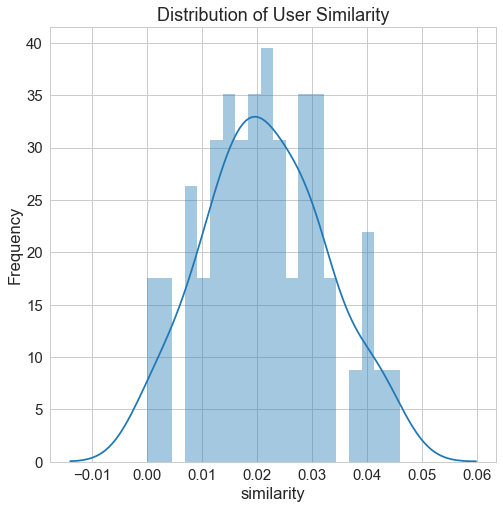

In [121]:
# Plot the distribution of users within each community
sns.set_style("whitegrid")    # Set style for seaborn output
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(8,8))
#plt.xticks(range) #np.arange(0,15,1))
plt.xlabel("Partition")
plt.ylabel("Frequency")
plt.title("Distribution of User Similarity", fontsize=18)

sns.distplot(sampled_users.similarity, bins=20, kde=True, rug=False);

#### The distribution above appears to be fairly normal with a mean around 0.2.  

Let's test for normality:

In [139]:
from scipy.stats import normaltest
from matplotlib import pyplot

value, p = normaltest(sampled_users.similarity)
print(value, p)

if p >= 0.05:
    print('\nSimilarity scores are likely normally distributed')
else:
    print('\nSimilarity scores are not likely normally distributed')

1.50046007562 0.47225790307

Similarity scores are likely normally distributed


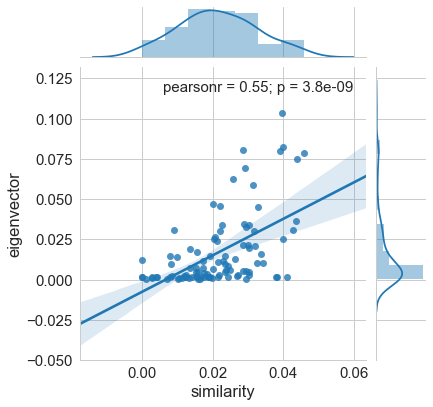

In [128]:
# eigenvector
sns.jointplot(x="similarity", y="eigenvector", data=sampled_users, kind="reg");

In [ ]:
# eigenvector
sns.jointplot(x="similarity", y="closeness", data=sampled_users, kind="reg");

***

### Analysis of Bipartite SubGraph projected on Businesses  

We will now consider the projection of the selected subgraph on businesses (restaurants in Pittsburgh). Restaurant A will be connected with Restaurant B if it has been reviewed by same user. The weight of the edge will be established by the number of times this pair of restaurant has been reviewed by a same user.

#### Augmenting data for businesses

For the analysis, we would like to gring a few attributes to the graph, name of restaurant, category (this will be reduce to a single value, for example; "Pizza, Restaurants" will be reduce to "Pizza"), and neighborhoods.

We will reduce the category to most relevant tag. To do so we will ignore categories such "Restaurants", "Bars", "Pubs", "Lounges", ... unless this is the only category possible for this restaurants. We are looking to analyse graph based on category.  

In [18]:
# Data Wrangling helper functions
def unique_category(s):
    """ This function will reduce a list of categories to a most relevant one"""
    #convert unicode to ascii
    b=s.encode('ascii', 'ignore')
    
    # strip c()
    if b[0:2]=='c(':
        c=b[2:-1]
    else:
        c = b
    
    # split each word separated by comma 
    l=c.split(',')    
    
    # Iterate over list and reduce to one category
    loop = True
    count = 0
    exclude = ['Restaurants', 'Bar', 'Nightlife', 'Pub', 'Pizza', 'Burgers', 'Gastropubs', 'Lounges', 'Chiken Wings', 'Ramen', 'Hot Dogs']
    limit = len(exclude)
    while (loop):    
        new = []
        for s in l:
            r=s.strip()
            r=r.strip('"')
            if exclude[count] not in r:
                new.append(r)
        # check lenght of new
        if len(new)==0:
            loop = False
            cat = exclude[count]
        
        elif len(new) == 1:
            loop = False
            cat=new[0]
    
        elif count == limit-1:
            loop = False
        
        else:
            l=new
            count = count + 1
        # End of while loop
        
    if len(new) > 1:
        cat=new[0]
    
    return(cat)

def isolate_zip(s):
    """ This function will isolate the zip code component from the full address"""
    
    #convert unicode to ascii
    b=s.encode('ascii', 'ignore')
    
    # split each word separated by comma 
    l=b.split(',')
    
    # Isolate zip code from last part of address
    str_zip=re.findall('\d+', l[-1])[0]
    
    return(str_zip)

def clean_neighborhoods(s):
    """ This function will clean-up neighborhoods value by remove unicode and replacing 'character(0)' by 'Unknown'"""
    #convert unicode to ascii
    b=s.encode('ascii', 'ignore')
    
    if (b=='character(0)'):
        b = 'Unknown'
    
    return(b)
    

In [19]:
idx_business = business.set_index(['business_id'])
idx_business.head(5)

name  \
business_id                                                                 
wqu7ILomIOPSduRwoWp4AQ                                            Denny's   
_jsJFrAmFVPRio0eEVExbA                                         McDonald's   
udZJ8YgsHdqtFDQkyPTV1Q                      Arby's Roast Beef Restaurants   
ZL6DNzyenFm9Kpz6uADlNg  Pino's Contemporary Italian Restaurant & Wine Bar   
OcTG-KzDleuRub-pb6JS3Q                                 Eddie's Pizza Haus   

                                                             full_address  \
business_id                                                                 
wqu7ILomIOPSduRwoWp4AQ          2180 Greentree Rd\r\nPittsburgh, PA 15220   
_jsJFrAmFVPRio0eEVExbA  4557 Ohio River Blvd\r\nBellevue\r\nPittsburgh...   
udZJ8YgsHdqtFDQkyPTV1Q  4260 Ohio River Blvd\r\nBellevue\r\nPittsburgh...   
ZL6DNzyenFm9Kpz6uADlNg  6738 Reynolds St\r\nPoint Breeze\r\nPittsburgh...   
OcTG-KzDleuRub-pb6JS3Q  1744 Chislett St\r\nMorningside\r\nPittsburgh,...   

                                                               categories  \
business_id                                                                 
wqu7ILomIOPSduRwoWp4AQ  c("Breakfast & Brunch", "American (Traditional...   
_jsJFrAmFVPRio0eEVExbA           c("Burgers", "Fast Food", "Restaurants")   
udZJ8YgsHdqtFDQkyPTV1Q                                        Restaurants   
ZL6DNzyenFm9Kpz6uADlNg  c("Tapas/Small Plates", "Restaurants", "Italian")   
OcTG-KzDleuRub-pb6JS3Q                          c("Pizza", "Restaurants")   

                              city state  review_count neighborhoods  
business_id                                                           
wqu7ILomIOPSduRwoWp4AQ  Pittsburgh    PA             7  character(0)  
_jsJFrAmFVPRio0eEVExbA  Pittsburgh    PA             4      Bellevue  
udZJ8YgsHdqtFDQkyPTV1Q  Pittsburgh    PA             3      Bellevue  
ZL6DNzyenFm9Kpz6uADlNg  Pittsburgh    PA            46  Point Breeze  
OcTG-KzDleuRub-pb6JS3Q  Pittsburgh    PA             5   Morningside

In [20]:
idx_business['unique_category'] = idx_business['categories'].apply(unique_category)
#idx_business['zip_code'] = idx_business['full_address'].apply(isolate_zip)
idx_business['neighborhoods'] = idx_business['neighborhoods'].apply(clean_neighborhoods)
#idx_business.loc[idx_business['neighborhoods'] =='character(0)', ['neighborhoods']]='Unknown'

idx_business.head(5)

name  \
business_id                                                                 
wqu7ILomIOPSduRwoWp4AQ                                            Denny's   
_jsJFrAmFVPRio0eEVExbA                                         McDonald's   
udZJ8YgsHdqtFDQkyPTV1Q                      Arby's Roast Beef Restaurants   
ZL6DNzyenFm9Kpz6uADlNg  Pino's Contemporary Italian Restaurant & Wine Bar   
OcTG-KzDleuRub-pb6JS3Q                                 Eddie's Pizza Haus   

                                                             full_address  \
business_id                                                                 
wqu7ILomIOPSduRwoWp4AQ          2180 Greentree Rd\r\nPittsburgh, PA 15220   
_jsJFrAmFVPRio0eEVExbA  4557 Ohio River Blvd\r\nBellevue\r\nPittsburgh...   
udZJ8YgsHdqtFDQkyPTV1Q  4260 Ohio River Blvd\r\nBellevue\r\nPittsburgh...   
ZL6DNzyenFm9Kpz6uADlNg  6738 Reynolds St\r\nPoint Breeze\r\nPittsburgh...   
OcTG-KzDleuRub-pb6JS3Q  1744 Chislett St\r\nMorningside\r\nPittsburgh,...   

                                                               categories  \
business_id                                                                 
wqu7ILomIOPSduRwoWp4AQ  c("Breakfast & Brunch", "American (Traditional...   
_jsJFrAmFVPRio0eEVExbA           c("Burgers", "Fast Food", "Restaurants")   
udZJ8YgsHdqtFDQkyPTV1Q                                        Restaurants   
ZL6DNzyenFm9Kpz6uADlNg  c("Tapas/Small Plates", "Restaurants", "Italian")   
OcTG-KzDleuRub-pb6JS3Q                          c("Pizza", "Restaurants")   

                              city state  review_count neighborhoods  \
business_id                                                            
wqu7ILomIOPSduRwoWp4AQ  Pittsburgh    PA             7       Unknown   
_jsJFrAmFVPRio0eEVExbA  Pittsburgh    PA             4      Bellevue   
udZJ8YgsHdqtFDQkyPTV1Q  Pittsburgh    PA             3      Bellevue   
ZL6DNzyenFm9Kpz6uADlNg  Pittsburgh    PA            46  Point Breeze   
OcTG-KzDleuRub-pb6JS3Q  Pittsburgh    PA             5   Morningside   

                           unique_category  
business_id                                 
wqu7ILomIOPSduRwoWp4AQ  Breakfast & Brunch  
_jsJFrAmFVPRio0eEVExbA           Fast Food  
udZJ8YgsHdqtFDQkyPTV1Q         Restaurants  
ZL6DNzyenFm9Kpz6uADlNg  Tapas/Small Plates  
OcTG-KzDleuRub-pb6JS3Q               Pizza

Before we add attributes to graph, we will confirm that the list of nodes in graph is matching or list of businesses in dataframe. The attributes we will be adding are: name, category, neighborhoods, and review count. 

In [21]:
# create data frame with nodes list
N=B.nodes()
df_bnodes = pd.DataFrame({'business_id':N})
df_bnodes.set_index('business_id', inplace=True)

In [22]:
# Perform a left join and identify nodes that are not in business dataframe
merged = pd.merge(df_bnodes, idx_business, how='left', left_index = True, right_index = True, indicator=True)

merged.loc[merged['_merge'] != 'both'].count()

name                0
full_address        0
categories          0
city                0
state               0
review_count        0
neighborhoods       0
unique_category     0
_merge             12
dtype: int64

In [23]:
# List nodes that are not in the business dataframe
drop_nodes = merged.loc[merged['_merge'] != 'both'].index.values.tolist()

For each node in the list of nodes not in the business data frame, we will remove it from the graph of business.

In [24]:
for n in drop_nodes:
    B.remove_node(n)

We will now proceed with adding the relevant attributes to the graph.

In [25]:
for i in sorted(B.nodes()):
    B.node[i]['name'] = idx_business.name[i]
    B.node[i]['category'] = idx_business.unique_category[i]
    B.node[i]['neighborhood'] = idx_business.neighborhoods[i]
    #B.node[i]['zip'] = idx_business.zip_code[i]    
    B.node[i]['review_count']=idx_business.review_count[i]

#### Initial Analysis of main business graph

We will find some basic information about this graph.  

In [26]:
print(nx.info(B))
print "Density: " + str(nx.density(B))
print "Is connected?: " + str(nx.is_connected(B))
print "Is bipartite?: " + str(nx.is_bipartite(B))

Name: 
Type: Graph
Number of nodes: 1207
Number of edges: 85125
Average degree: 141.0522
Density: 0.116958702758
Is connected?: False
Is bipartite?: False


We will now draw the graph.

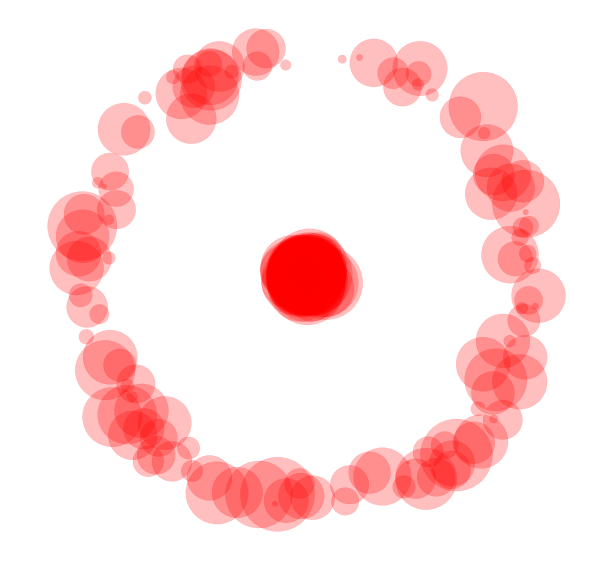

In [27]:
# Set the size of frame for drawing
plt.figure(figsize=(10,10))
plt.axis("off")

spring_pos = nx.spring_layout(B)
nx.draw(B, spring_pos, node_size=[v*10 for v in B.degree().values()], with_labels=False, node_color='red', alpha=.25)

Using the island method, we will reduce the size of the network under analysis by trimming some nodes.  

In [28]:
## Apply Island Analysis on the business nodes
cc = list(nx.connected_component_subgraphs(B))[0]
islands = island_method(cc)

print ('Weight  Restaurant  Groups')
for i in islands:
    print(' %d          %2d       %d' 
          %(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))

Weight  Restaurant  Groups
 1          797       1
 8          138       2
 15          42       1
 22          12       1
 29           3       1
 36           2       1


These results confirm the original untrimmed grah where the nodes very concentrated.  We will consider the water level of 15 and 8 for the remaining of the analysis.  With level 8 we are introducing another group (which will prove trivial). 

In [29]:
# apply a minimum weight 8 & 15 water levels
bsub8 = trim_edges(B, 8)
bsub8.graph['name']='Business subgraph water level 8'

bsub15 = trim_edges(B, 15)
bsub15.graph['name']='Business subgraph water level 15'

The attributes from the parent graph are not kept after the trimming. Hence, we will rebuild the attributes for each subgraph.

In [73]:
# create data frame with nodes list - For trimmed Water Level 8 Graph
bsub8_nodes=bsub8.nodes()
df_bsub8 = pd.DataFrame({'business_id':bsub8_nodes})
df_bsub8.set_index('business_id', inplace=True)

# Inner join nodes with main business data frame
df_bsub8_atr = df_bsub8.join(idx_business, how='inner')

df_bsub8_atr['zip_code'] = df_bsub8_atr['full_address'].apply(isolate_zip)

# display first 5 records
df_bsub8_atr.head(5)

name  \
business_id                                               
Ca-003BAqWW-IEsFvjlY9g                    Rose Tea Cafe   
ffVx7PrC2JSfOq_DTW-vZQ  Verde Mexican Kitchen & Cantina   
Uiz1Xq1I6jdnDLtzIIF9hQ              Butcher and the Rye   
rXb8s7TOx2-uWxzACEXcpg                 Six Penn Kitchen   
Zg5JB5GBqhmxt9W7tFKN7w                      The Library   

                                                             full_address  \
business_id                                                                 
Ca-003BAqWW-IEsFvjlY9g  5874 1/2 Forbes Ave\r\nSquirrel Hill\r\nPittsb...   
ffVx7PrC2JSfOq_DTW-vZQ  5491 Penn Ave\r\nGarfield\r\nPittsburgh, PA 15206   
Uiz1Xq1I6jdnDLtzIIF9hQ     212 6th St\r\nDowntown\r\nPittsburgh, PA 15222   
rXb8s7TOx2-uWxzACEXcpg     146 6th St\r\nDowntown\r\nPittsburgh, PA 15222   
Zg5JB5GBqhmxt9W7tFKN7w  2304 E Carson St\r\nSouth Side\r\nPittsburgh, ...   

                                                        categories  \
business_id                                                          
Ca-003BAqWW-IEsFvjlY9g    c("Taiwanese", "Chinese", "Restaurants")   
ffVx7PrC2JSfOq_DTW-vZQ                 c("Mexican", "Restaurants")   
Uiz1Xq1I6jdnDLtzIIF9hQ          c("American (New)", "Restaurants")   
rXb8s7TOx2-uWxzACEXcpg          c("American (New)", "Restaurants")   
Zg5JB5GBqhmxt9W7tFKN7w  c("American (Traditional)", "Restaurants")   

                              city state  review_count  neighborhoods  \
business_id                                                             
Ca-003BAqWW-IEsFvjlY9g  Pittsburgh    PA           212  Squirrel Hill   
ffVx7PrC2JSfOq_DTW-vZQ  Pittsburgh    PA           231       Garfield   
Uiz1Xq1I6jdnDLtzIIF9hQ  Pittsburgh    PA           169       Downtown   
rXb8s7TOx2-uWxzACEXcpg  Pittsburgh    PA           178       Downtown   
Zg5JB5GBqhmxt9W7tFKN7w  Pittsburgh    PA           118     South Side   

                               unique_category zip_code  
business_id                                              
Ca-003BAqWW-IEsFvjlY9g               Taiwanese    15217  
ffVx7PrC2JSfOq_DTW-vZQ                 Mexican    15206  
Uiz1Xq1I6jdnDLtzIIF9hQ          American (New)    15222  
rXb8s7TOx2-uWxzACEXcpg          American (New)    15222  
Zg5JB5GBqhmxt9W7tFKN7w  American (Traditional)    15203

We will add all the attributes; name, unique_category, neighborhood, review_count, and zip to respective node in the graph. 

In [72]:
for i in sorted(bsub8.nodes()):
    bsub8.node[i]['name'] = df_bsub8_atr.name[i]
    bsub8.node[i]['category'] = df_bsub8_atr.unique_category[i]
    bsub8.node[i]['neighborhood'] = df_bsub8_atr.neighborhoods[i]
    bsub8.node[i]['zip'] = df_bsub8_atr.zip_code[i]    
    bsub8.node[i]['review_count']=df_bsub8_atr.review_count[i]

# Since bsub15 is a subset of bsub8
for i in sorted(bsub15.nodes()):
    bsub15.node[i]['name'] = df_bsub8_atr.name[i]
    bsub15.node[i]['category'] = df_bsub8_atr.unique_category[i]
    bsub15.node[i]['neighborhood'] = df_bsub8_atr.neighborhoods[i]
    bsub15.node[i]['zip'] = df_bsub8_atr.zip_code[i]    
    bsub15.node[i]['review_count']=df_bsub8_atr.review_count[i]

#### Subgraph - water level 8

We will start by focusing on the subgraph generated by water level 8. We will first look at general information about this graph.

In [32]:
print(nx.info(bsub8))
print "Is connected?: " + str(nx.is_connected(bsub8))
print "Is bipartite?: " + str(nx.is_bipartite(bsub8))
print "Density: " + str(nx.density(bsub8))

Name: Business subgraph water level 8
Type: Graph
Number of nodes: 138
Number of edges: 702
Average degree:  10.1739
Is connected?: False
Is bipartite?: False
Density: 0.0742621390035


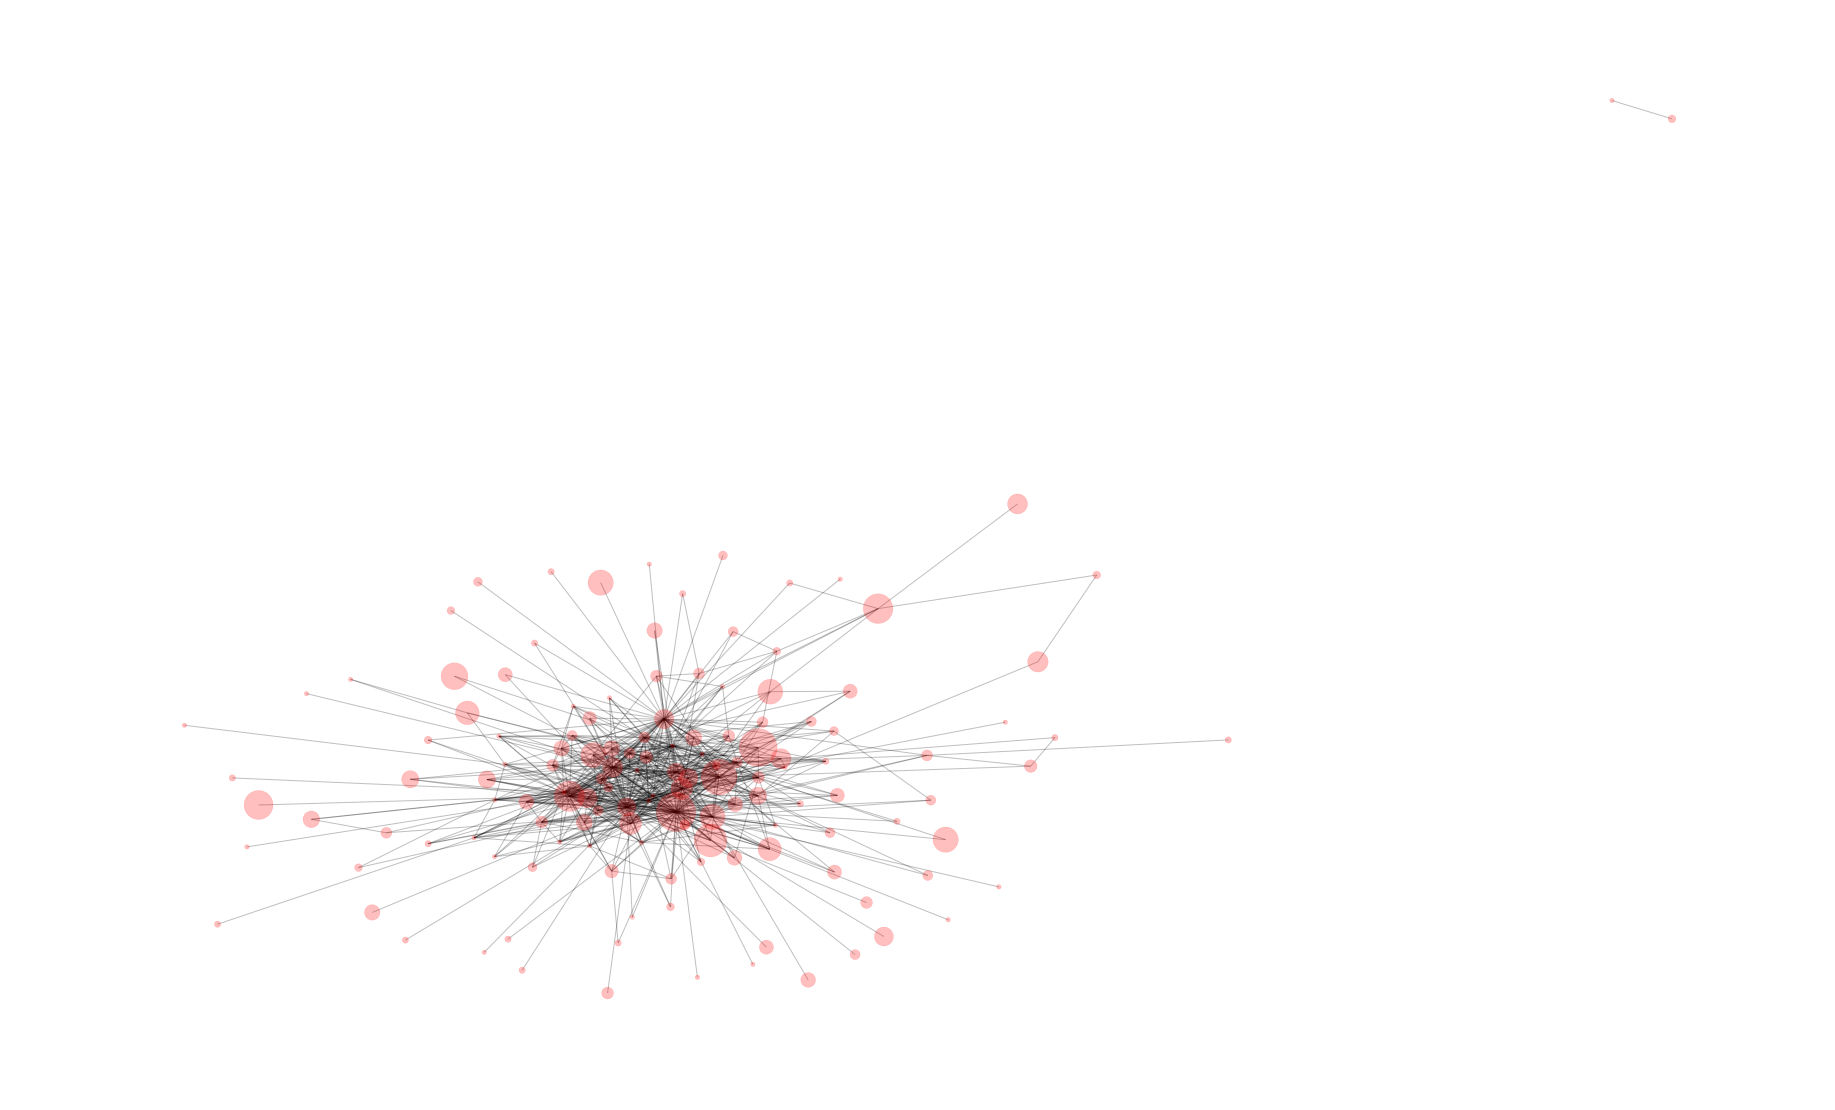

In [77]:
pos8 = nx.spring_layout(bsub8)
nx.draw(bsub8, pos8, node_size=[v*20 for v in bsub8.degree().values()], with_labels=False, node_color='r', alpha=.25, font_size=20)

We will differenciate the edges based on weights. To do so, we will assign weight size and color in interval of 10 (i.e. 0-9, , 10-19, 20-29, 30-39, >40).  

In [33]:
e8_1=[(u,v) for (u,v,d) in bsub8.edges(data=True) if d['weight'] in range(0,10)]
e8_2=[(u,v) for (u,v,d) in bsub8.edges(data=True) if d['weight'] in range(10,20)]
e8_3=[(u,v) for (u,v,d) in bsub8.edges(data=True) if d['weight'] in range(20,30)]
e8_4=[(u,v) for (u,v,d) in bsub8.edges(data=True) if d['weight'] in range(30,40)]      
e8_5=[(u,v) for (u,v,d) in bsub8.edges(data=True) if d['weight'] >=40]

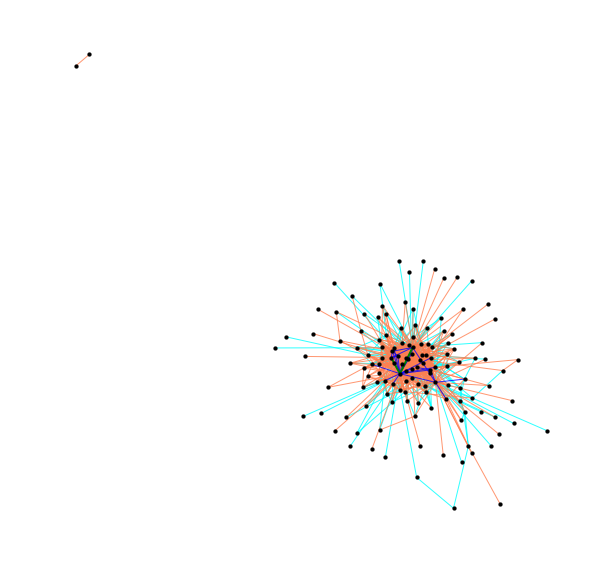

In [34]:
# Set the size of frame for drawing
plt.figure(figsize=(10,10))
plt.axis("off")

# Nodes Layout      
pos8 = nx.spring_layout(bsub8)

# nodes
nx.draw_networkx_nodes(bsub8,pos8,node_size=15, with_labels=False, node_color='black', alpha=1)

# edges
nx.draw_networkx_edges(bsub8,pos8,edgelist=e8_1,width=1, alpha=0.8, edge_color = 'cyan')
nx.draw_networkx_edges(bsub8,pos8,edgelist=e8_2, width=1, alpha=0.8,edge_color = 'coral')
nx.draw_networkx_edges(bsub8,pos8,edgelist=e8_3, width=1, alpha=0.8,edge_color = 'blue')
nx.draw_networkx_edges(bsub8,pos8,edgelist=e8_4, width=2, alpha=1,edge_color = 'green')
nx.draw_networkx_edges(bsub8,pos8,edgelist=e8_5, width=4, alpha=0,edge_color = 'purple')


Due to high number of edges in this graph, it is clear the majority of edges have weights below 20 represented in color cyan and coral while the edges with weights from 20 to 29 are colored in blue and the egdes with weight higher than 30 are in green.  

The group introduced by the trimming is actually trivial group of 2 nodes.  This is unsurprising since the original graph was very connected.

We are now look at the centrality measures for our businesses subgraph. We will first look at the degree centrality for the graph.

#### Centrality measures for subgraph (8)

In [35]:
def sorted_map(map):
    ms=sorted(map.iteritems(), key=lambda(k,v):(-v,k))
    return ms

# Centrality Measure
bsub8_deg = nx.degree_centrality(bsub8)

ds=sorted_map(bsub8_deg)

We will display the top ten nodes by degree centrality and plot the histogram.

In [36]:
ds[0:5]

[('SsGNAc9U-aKPZccnaDtFkA', 0.5620437956204379),
 ('rcCGdKxMPJk4lCzZZ1i_bA', 0.5255474452554745),
 ('RjavzMXChoFWdsIZnfs5YQ', 0.46715328467153283),
 ('Nui7Cnhrhrm4Ar2rcSHbIA', 0.3941605839416058),
 ('Uiz1Xq1I6jdnDLtzIIF9hQ', 0.3357664233576642)]

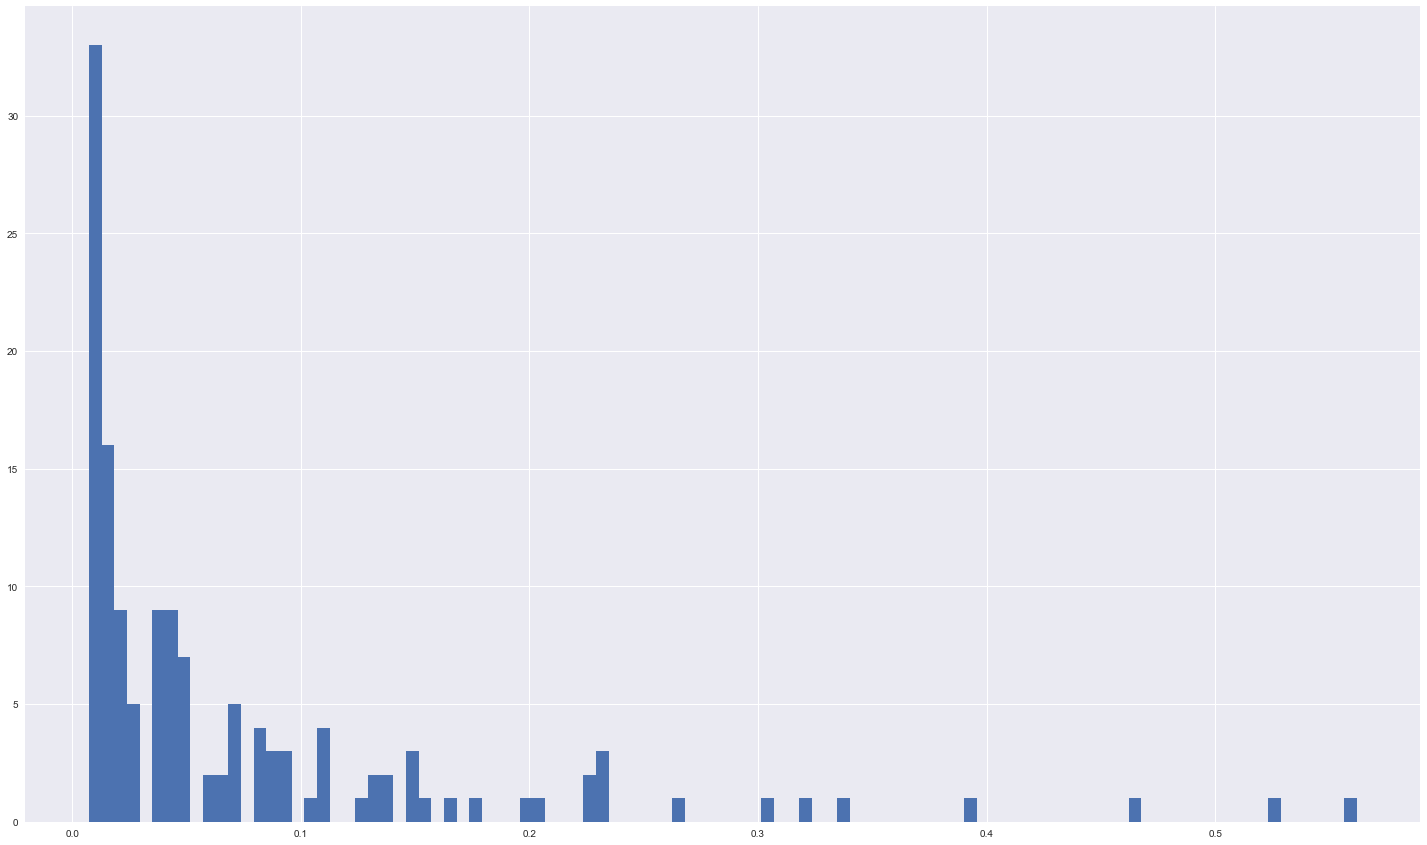

In [37]:
# Plot Histogram of degrees
h=plt.hist(bsub8_deg.values(), 100)

From the histogram, we can see that we have a few restaurants that have degree centrality above 30%, we will look at the details of these nodes.

In [38]:
print str(df_bsub8_atr.loc['SsGNAc9U-aKPZccnaDtFkA'])
print "---------------------------------------------"
print str(df_bsub8_atr.loc['rcCGdKxMPJk4lCzZZ1i_bA'])
print "---------------------------------------------"
print str(df_bsub8_atr.loc['RjavzMXChoFWdsIZnfs5YQ'])
print "---------------------------------------------"
print str(df_bsub8_atr.loc['Nui7Cnhrhrm4Ar2rcSHbIA'])
print "---------------------------------------------"
print str(df_bsub8_atr.loc['Uiz1Xq1I6jdnDLtzIIF9hQ'])

name                                                Meat & Potatoes
full_address       649 Penn Ave\r\nDowntown\r\nPittsburgh, PA 15222
categories         c("Gastropubs", "American (New)", "Restaurants")
city                                                     Pittsburgh
state                                                            PA
review_count                                                    657
neighborhoods                                              Downtown
unique_category                                      American (New)
zip_code                                                      15222
Name: SsGNAc9U-aKPZccnaDtFkA, dtype: object
---------------------------------------------
name                                       Gaucho Parrilla Argentina
full_address       1607 Penn Ave\r\nStrip District\r\nPittsburgh,...
categories                        c("Latin American", "Restaurants")
city                                                      Pittsburgh
state                 

Restaurant "Meat & Potatoes" and "Gaucho Parrilla Argentina" are the restaurants with the two highest degree centrality measure. This would indicate that they have been reviewed by the same user in conjunction with another other restaurants most often.  

We will now consider "Closeness Centrality" measure.  


In [39]:
# Closeness Centrality
bsub8_clos = nx.closeness_centrality(bsub8)

In [40]:
ds=sorted_map(bsub8_clos)

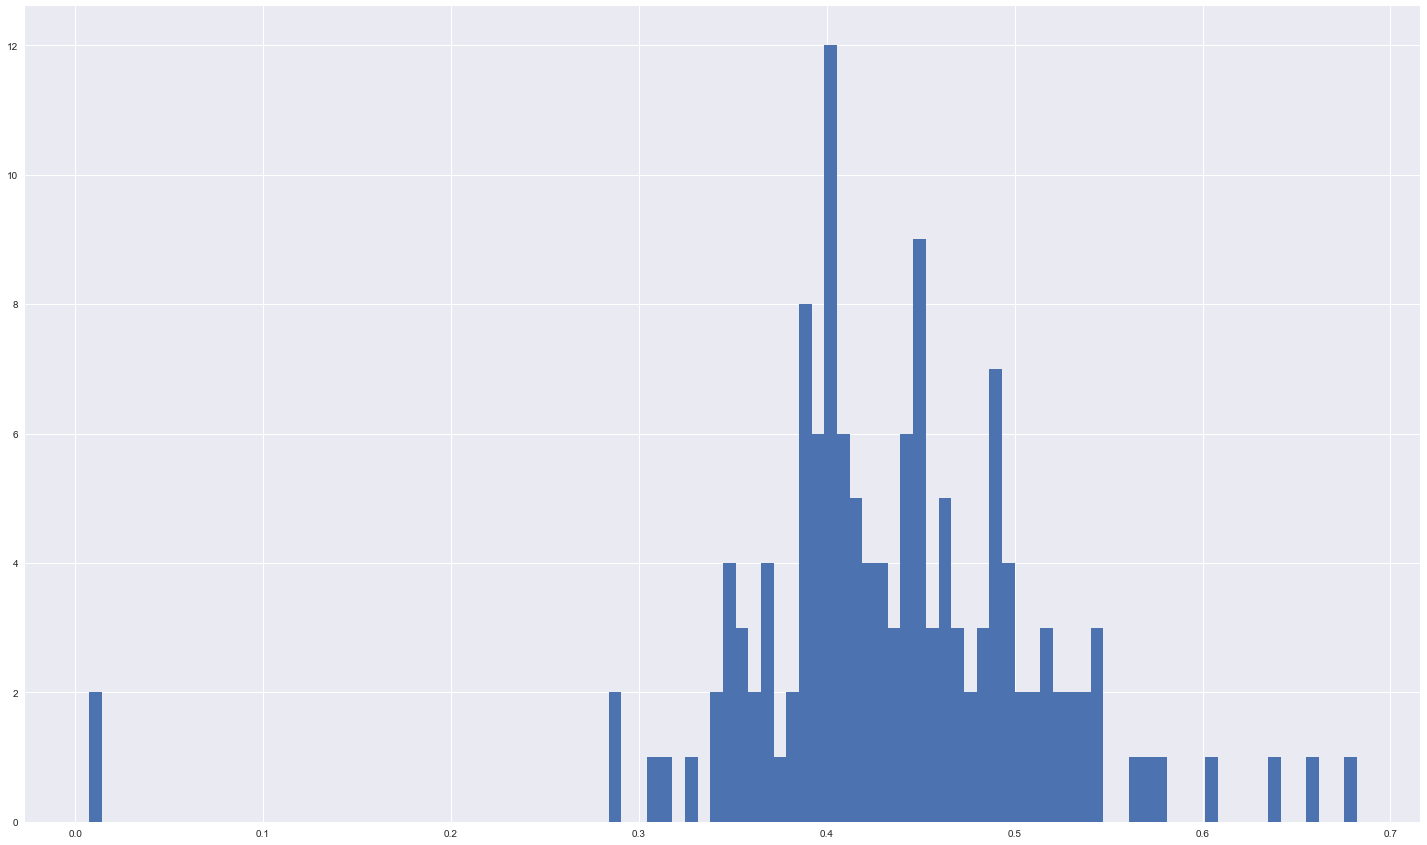

In [41]:
h=plt.hist(bsub8_clos.values(), 100)

The histogram reflect the plot of the subgraph, from this we can recognize the 2 nodes that are quite separate from the others in the graph. We will have a closer look at these nodes as well with the nodes with the highest closeness.  


In [42]:
ds[136:138]

[('1vK7gWQ_b5ehAyOidOsYtg', 0.0072992700729927005),
 ('52CzJDb4EakSjEQOUys77Q', 0.0072992700729927005)]

In [43]:
print str(df_bsub8_atr.loc['1vK7gWQ_b5ehAyOidOsYtg', : ])
print "--------------------------------------------"
print str(df_bsub8_atr.loc['52CzJDb4EakSjEQOUys77Q', : ])

name                                                  Aiello's Pizza
full_address       2112 Murray Ave\r\nSquirrel Hill\r\nPittsburgh...
categories                      c("Italian", "Pizza", "Restaurants")
city                                                      Pittsburgh
state                                                             PA
review_count                                                     115
neighborhoods                                          Squirrel Hill
unique_category                                              Italian
zip_code                                                       15217
Name: 1vK7gWQ_b5ehAyOidOsYtg, dtype: object
--------------------------------------------
name                                             Mineo's Pizza House
full_address       2128 Murray Ave\r\nSquirrel Hill\r\nPittsburgh...
categories                                 c("Pizza", "Restaurants")
city                                                      Pittsburgh
state         

For these 2 restaurants, we have all 3 attributes that are similar; zip, neighborhood, and category.  

We will now look at the nodes with highest closeness.  


In [44]:
ds[0:5]

[('SsGNAc9U-aKPZccnaDtFkA', 0.682201010668164),
 ('rcCGdKxMPJk4lCzZZ1i_bA', 0.6618368013944875),
 ('RjavzMXChoFWdsIZnfs5YQ', 0.6365033353124018),
 ('Nui7Cnhrhrm4Ar2rcSHbIA', 0.6074392560743926),
 ('Uiz1Xq1I6jdnDLtzIIF9hQ', 0.5783878133925738)]

In [45]:
print str(df_bsub8_atr.loc['SsGNAc9U-aKPZccnaDtFkA'])
print "---------------------------------------------"
print str(df_bsub8_atr.loc['rcCGdKxMPJk4lCzZZ1i_bA'])
print "---------------------------------------------"
print str(df_bsub8_atr.loc['RjavzMXChoFWdsIZnfs5YQ'])
print "---------------------------------------------"
print str(df_bsub8_atr.loc['Nui7Cnhrhrm4Ar2rcSHbIA'])
print "---------------------------------------------"
print str(df_bsub8_atr.loc['Uiz1Xq1I6jdnDLtzIIF9hQ'])

name                                                Meat & Potatoes
full_address       649 Penn Ave\r\nDowntown\r\nPittsburgh, PA 15222
categories         c("Gastropubs", "American (New)", "Restaurants")
city                                                     Pittsburgh
state                                                            PA
review_count                                                    657
neighborhoods                                              Downtown
unique_category                                      American (New)
zip_code                                                      15222
Name: SsGNAc9U-aKPZccnaDtFkA, dtype: object
---------------------------------------------
name                                       Gaucho Parrilla Argentina
full_address       1607 Penn Ave\r\nStrip District\r\nPittsburgh,...
categories                        c("Latin American", "Restaurants")
city                                                      Pittsburgh
state                 

The same top 5 nodes that have highest degree centrality have the highest closeness centrality measure.  

We will finally look at the betweeness measure.  


In [46]:
## Betweeness Centrality
bsub8_bet = nx.betweenness_centrality(bsub8)

In [47]:
ds=sorted_map(bsub8_bet)

ds[0:5]

[('SsGNAc9U-aKPZccnaDtFkA', 0.22855195992706331),
 ('RjavzMXChoFWdsIZnfs5YQ', 0.2155324903987514),
 ('rcCGdKxMPJk4lCzZZ1i_bA', 0.19702762506480126),
 ('Nui7Cnhrhrm4Ar2rcSHbIA', 0.07469249964152637),
 ('Uiz1Xq1I6jdnDLtzIIF9hQ', 0.052627646277563896)]

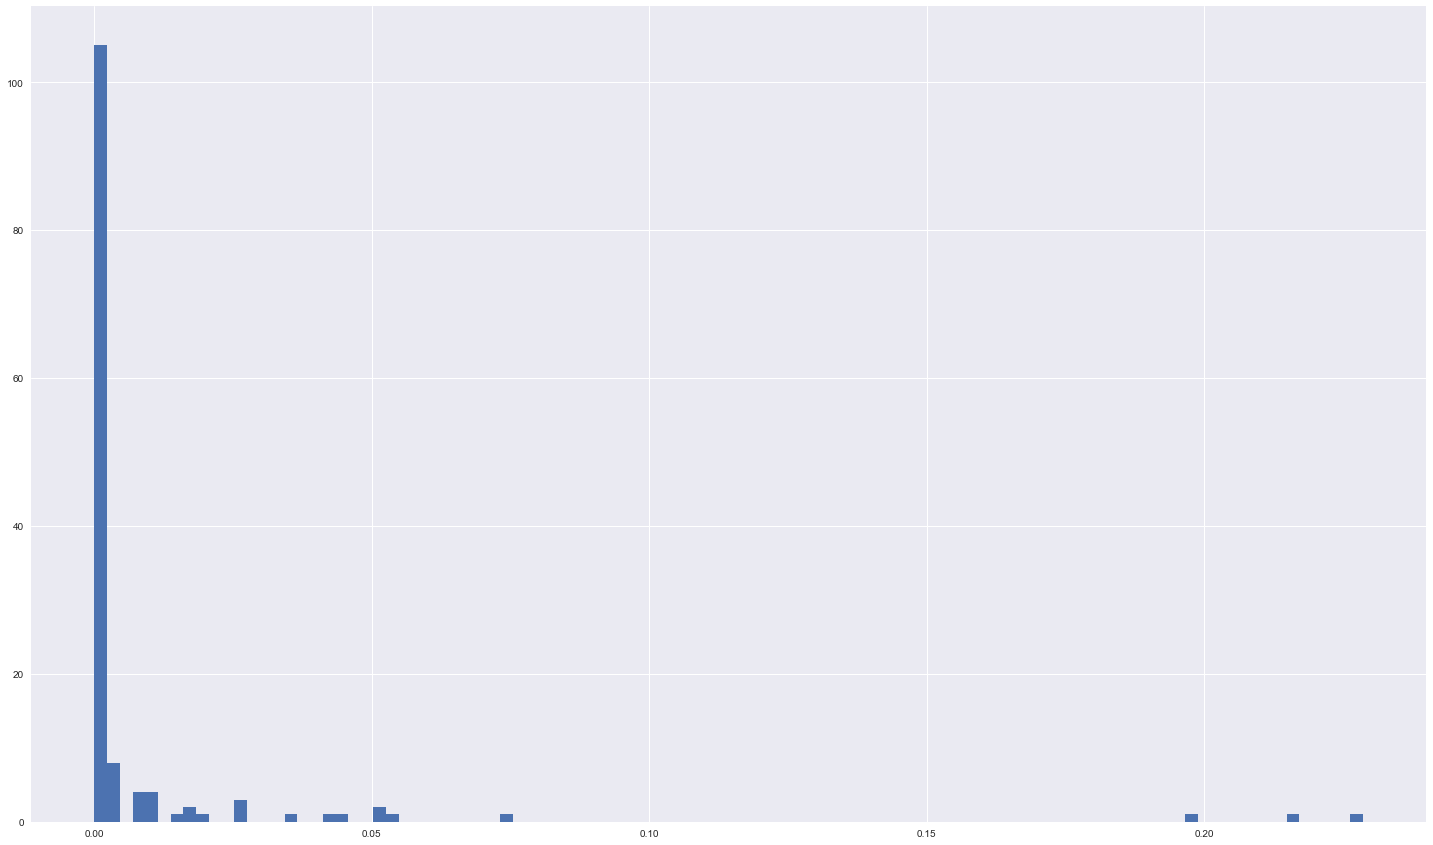

In [48]:
h=plt.hist(bsub8_bet.values(), 100)

Again, the same 5 nodes are at the top although for betweeness, the top 3 have higher betweenes measure.  

Finally we will determine the eigenvector centrality measure.  


In [49]:
## Eigenvector Centrality
bsub8_eig = nx.eigenvector_centrality(bsub8)

In [50]:
ds=sorted_map(bsub8_eig)

ds[0:5]

[('SsGNAc9U-aKPZccnaDtFkA', 0.3774634214165592),
 ('rcCGdKxMPJk4lCzZZ1i_bA', 0.2994239836478959),
 ('RjavzMXChoFWdsIZnfs5YQ', 0.2412845089580031),
 ('Nui7Cnhrhrm4Ar2rcSHbIA', 0.23661467640207257),
 ('Uiz1Xq1I6jdnDLtzIIF9hQ', 0.23130188502745333)]

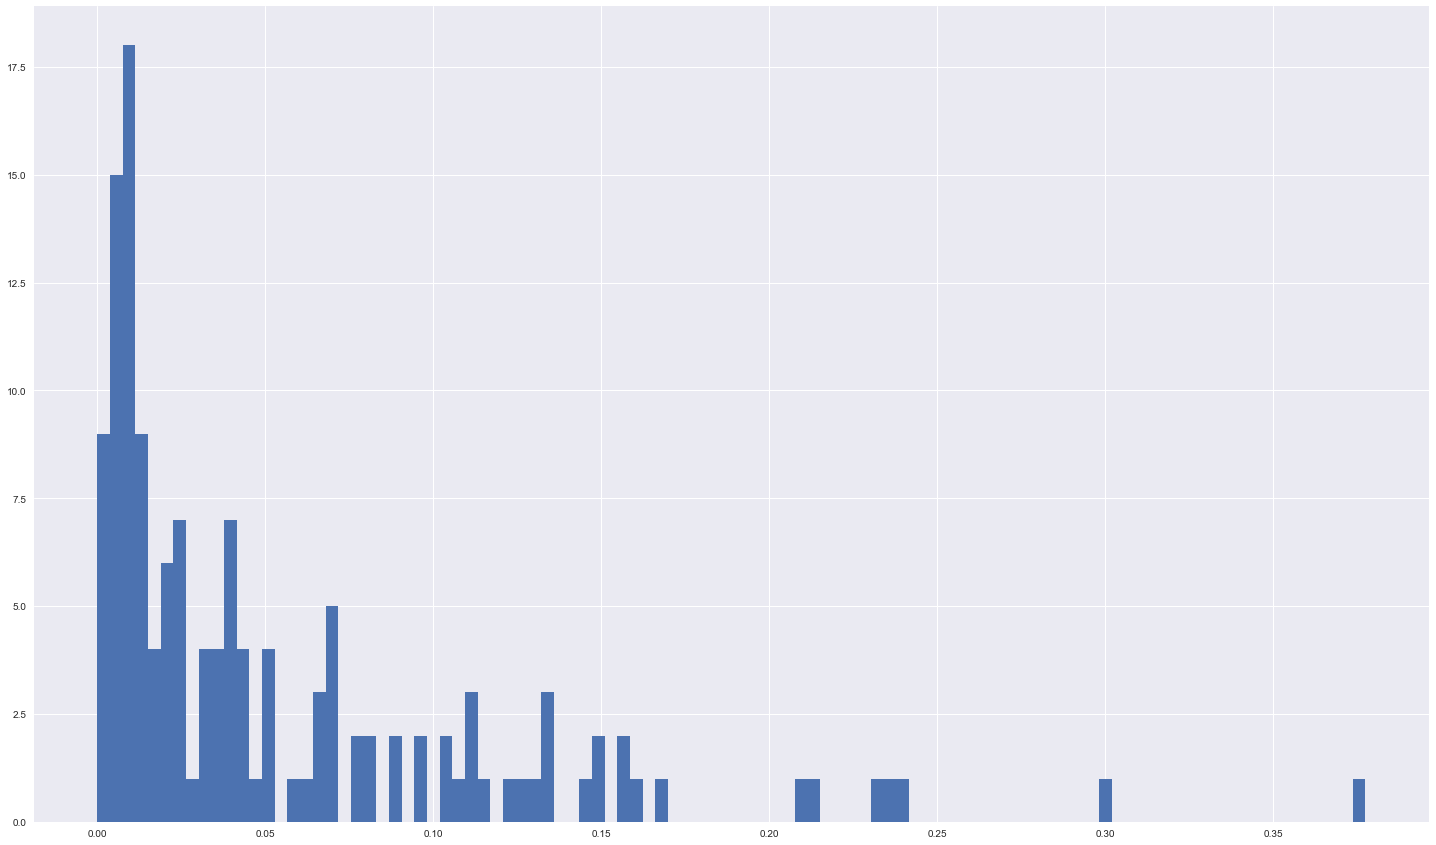

In [51]:
h=plt.hist(bsub8_eig.values(), 100)

Again, the top 5 are the same restaurants in a slightly different order.

They provide different cuisine experiences, are located in different neighborhoods, and 3 out of 5 are in the same zip code. We will draw the graph again with color mapping for categories, neighborhoods, and zip codes, each in its own graph.  

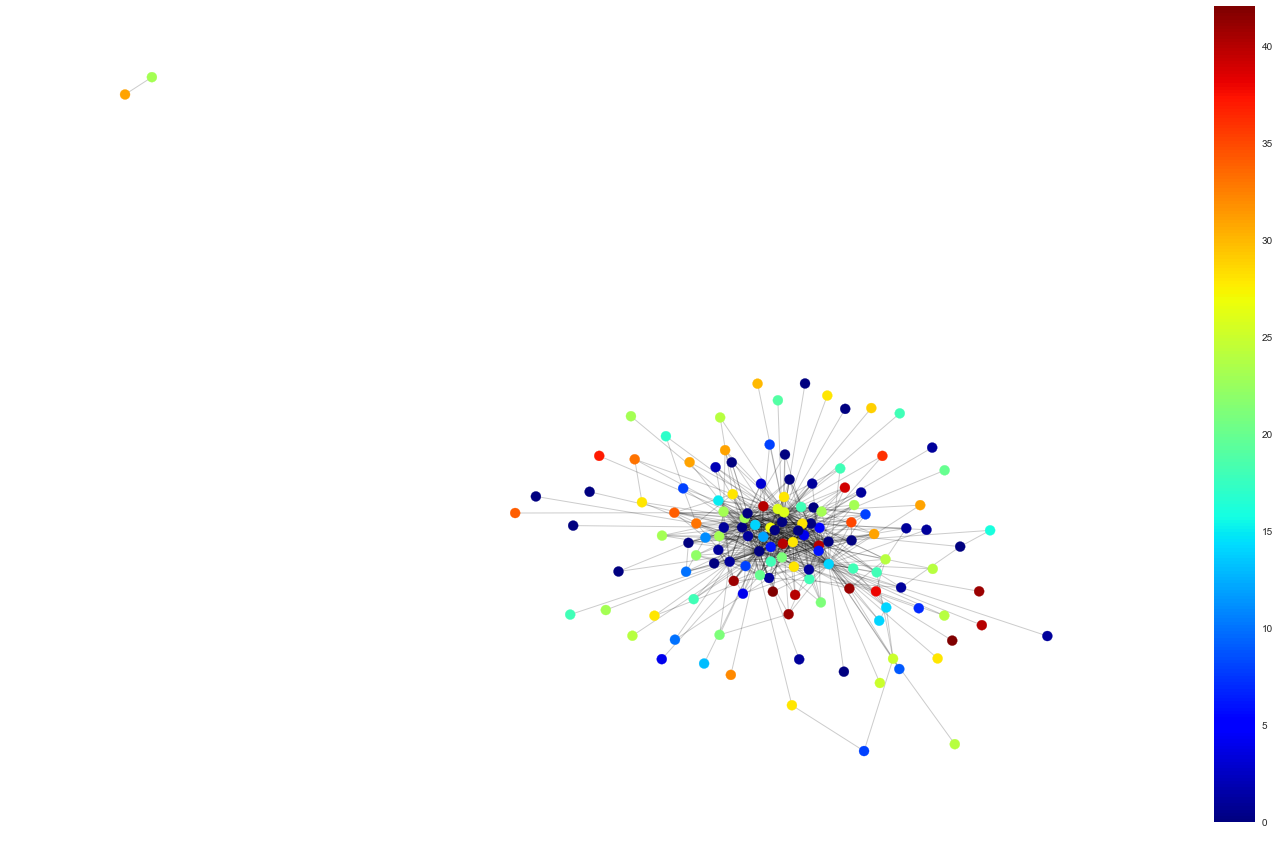

In [52]:
# get unique groups
categories = set(nx.get_node_attributes(bsub8,'category').values())
mapping = dict(zip(sorted(categories),count()))
nodes = bsub8.nodes()
colors_cat = [mapping[bsub8.node[n]['category']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colorbar
ec = nx.draw_networkx_edges(bsub8, pos8, alpha=0.2)
nc = nx.draw_networkx_nodes(bsub8, pos8, nodelist=nodes, node_color=colors_cat, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)

plt.colorbar(nc, orientation = 'vertical')
plt.axis('off')
plt.show()

Based on the color-coded graph, there does not appear to be any cluster or grouping based on category of restaurant. We have to remember, that we may have assign a different category the the restaurant.  

We will now take a look at a graph color-coded by neighborhoods.  


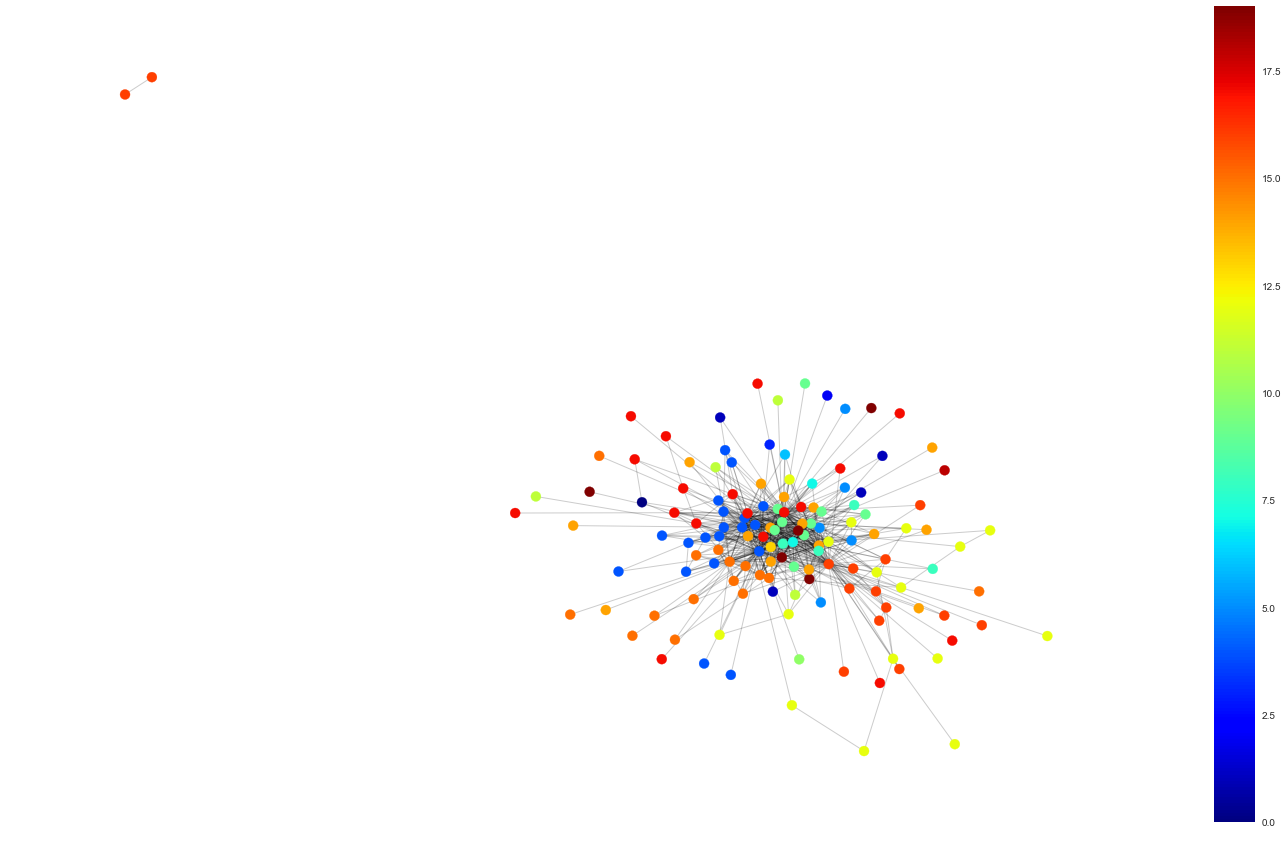

In [53]:
# From following stream from stackoverflow:
# https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt

# get unique neighborhood
neighborhoods = set(nx.get_node_attributes(bsub8,'neighborhood').values())
mapping = dict(zip(sorted(neighborhoods),count()))
nodes = bsub8.nodes()
colors_neigh = [mapping[bsub8.node[n]['neighborhood']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colorbar
ec = nx.draw_networkx_edges(bsub8, pos8, alpha=0.2)
nc = nx.draw_networkx_nodes(bsub8, pos8, nodelist=nodes, node_color=colors_neigh, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)

plt.colorbar(nc, orientation = 'vertical')
plt.axis('off')
plt.show()

Based on the color-coded graph for neighborhoods, it appears that restaurants in the same neighborhood are closer together. We will perform the same color-coded graph for zip codes.

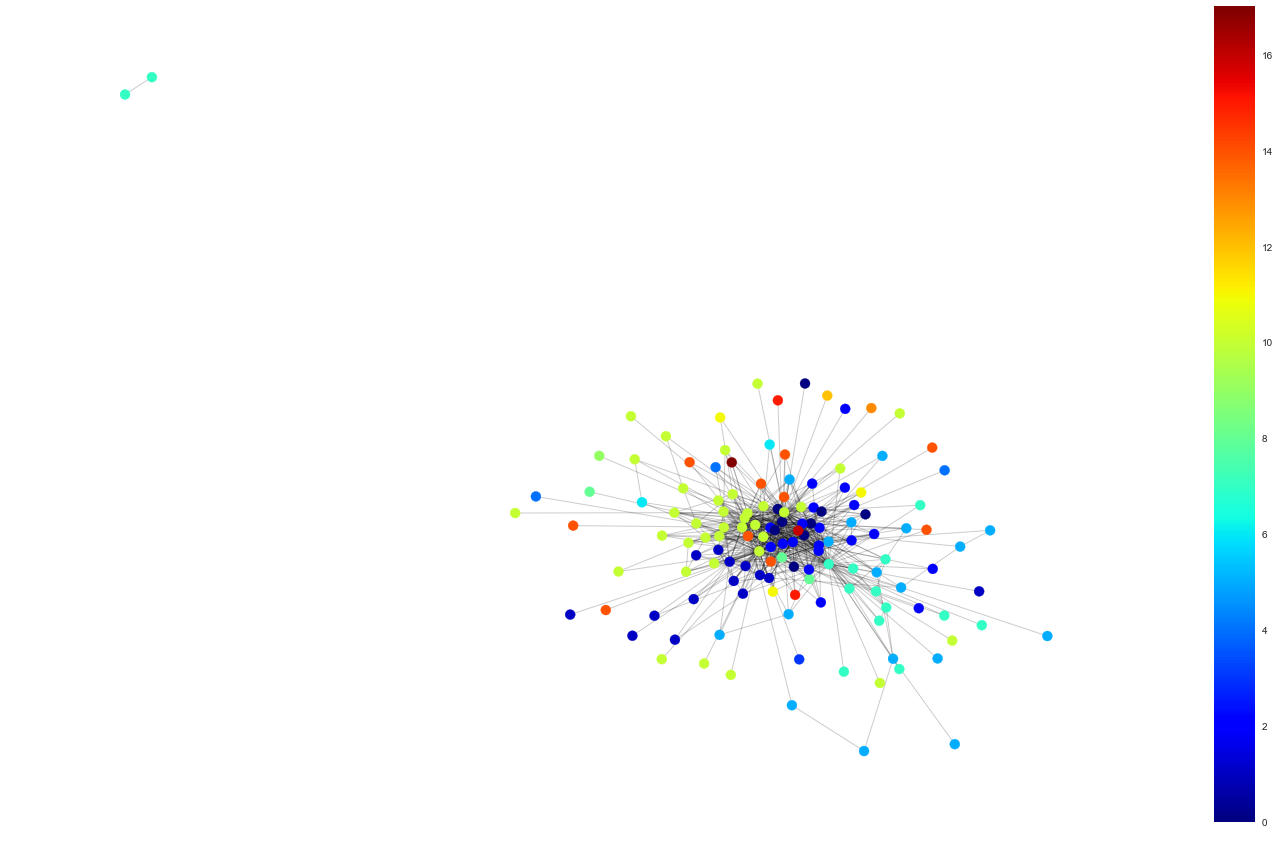

In [54]:
# get unique groups
zipcodes = set(nx.get_node_attributes(bsub8,'zip').values())
mapping = dict(zip(sorted(zipcodes),count()))
nodes = bsub8.nodes()
colors_zip = [mapping[bsub8.node[n]['zip']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colorbar
ec = nx.draw_networkx_edges(bsub8, pos8, alpha=0.2)
nc = nx.draw_networkx_nodes(bsub8, pos8, nodelist=nodes, node_color=colors_zip, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)

plt.colorbar(nc, orientation = 'vertical')
plt.axis('off')
plt.show()

Based on the colored coded graph, it appears that a similar pattern exist for zip code that we first saw for neighborhoods. We will analyse cluster and components and determined whether these are formed along zip codes. 

We will look at echo networks we will pick as "starting" node, the restaurant with the highest centrality measure in each zip code. We will print each graph color-coded and have each zip code identified by a node shape.  We will then be able to determine whether we have correlation between these 2 method of subgraphing the network.  

To do this, we will add the centrality measures to the business data frame and pick the for each zip code the restaurant with the highest score. 

In [55]:
bsub8_cm = {
    'degree': bsub8_deg,
    'eigenvector': bsub8_eig,
    'betweenness': bsub8_bet,
    'closeness': bsub8_clos
}

df_bsub8_cm = pd.DataFrame(bsub8_cm)

df_bsub8_cm.head(5)

betweenness  closeness    degree  eigenvector
-Mh44q324VW8mpxIdH_HPw     0.000227   0.465137  0.051095     0.041415
-XN4Oi0UCBK7rE3MsSXdqw     0.000000   0.397102  0.007299     0.009055
-a22bjfNCVL0gvKpd6RakA     0.025220   0.399487  0.051095     0.011498
-b9ZUSmcsGxutDSW1DIbdA     0.000364   0.447910  0.058394     0.042488
-vVQyTVHitF6TOHGijVXxQ     0.043921   0.525807  0.233577     0.149182

In [56]:
# Inner join centrality measures with main business data frame
df_bsub8_a = df_bsub8_cm.join(df_bsub8_atr, how='inner')

# Index on zip code and business_id
d = df_bsub8_a.reset_index()
idx_df_bsub8_a = d.set_index(['zip_code', 'index'])

idx_df_bsub8_a.groupby('zip_code')['eigenvector'].idxmax()


zip_code
15201    (15201, Nui7Cnhrhrm4Ar2rcSHbIA)
15203    (15203, -vVQyTVHitF6TOHGijVXxQ)
15206    (15206, ihUWFwY0r3ApW5aZ4Aqf9Q)
15211    (15211, _WaHLgLzALd2iThQAhC-sQ)
15212    (15212, rE0-KhjcOQOWIaiybjsDZw)
15213    (15213, rfy_bJ5ad-gfVmMeqKtsyw)
15216    (15216, 2Igiyhi82R8_QaaPplRmCw)
15217    (15217, RjavzMXChoFWdsIZnfs5YQ)
15218    (15218, 2X5G4Ujq0s4Wfn4TC7gX0g)
15219    (15219, 63rmr1oM0BbAXcUfNEaieQ)
15222    (15222, SsGNAc9U-aKPZccnaDtFkA)
15224    (15224, dxCqGkhtXq-9fYEsX7Mf6Q)
15226    (15226, QR_Nmup1tRj1WwooAKePbg)
15228    (15228, -XN4Oi0UCBK7rE3MsSXdqw)
15232    (15232, rgmptwPbBH1wLpiBHcbIhA)
15233    (15233, wQ3klyJeDhIQUIZS2X5r7Q)
15238    (15238, x8GTTMIAtUJ5EsIMnsOacQ)
15289    (15289, 0ayh3LxJwSbJEOlBCx9APA)
Name: eigenvector, dtype: object

In [58]:
df_bsub8_atr.loc['Nui7Cnhrhrm4Ar2rcSHbIA']

name                                           Industry Public House
full_address       4305 Butler St\r\nLawrenceville\r\nPittsburgh,...
categories         c("Bars", "American (New)", "Cocktail Bars", "...
city                                                      Pittsburgh
state                                                             PA
review_count                                                     211
neighborhoods                                          Lawrenceville
unique_category                                       American (New)
zip_code                                                       15201
Name: Nui7Cnhrhrm4Ar2rcSHbIA, dtype: object

In [61]:
s_15201 = nx.ego_graph(bsub8, n='Nui7Cnhrhrm4Ar2rcSHbIA', radius = 1, center=True)

print(nx.info(s_15201))

Name: Business subgraph water level 8
Type: Graph
Number of nodes: 55
Number of edges: 434
Average degree:  15.7818


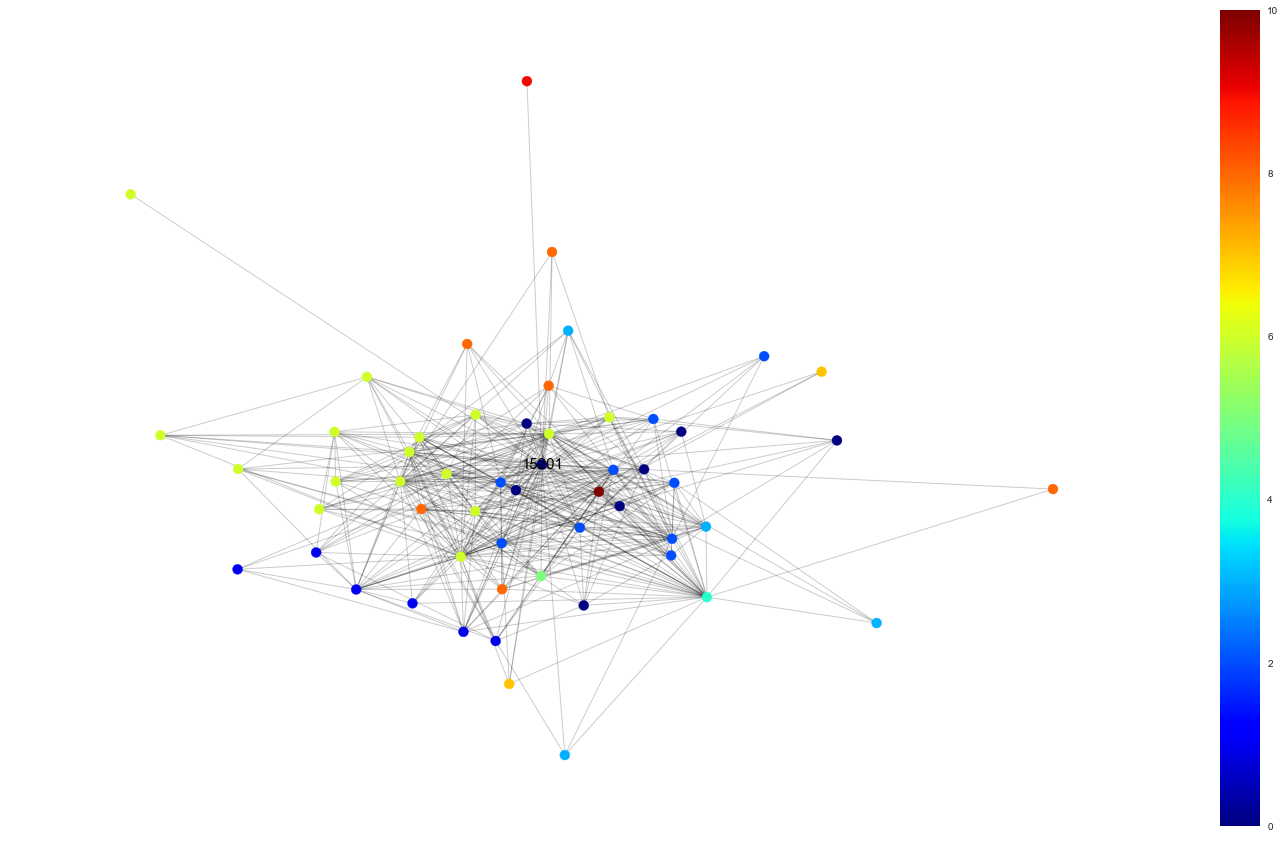

In [62]:
# get unique groups
zipcodes = set(nx.get_node_attributes(s_15201,'zip').values())
mapping = dict(zip(sorted(zipcodes),count()))
nodes = s_15201.nodes()
colors_zip = [mapping[s_15201.node[n]['zip']] for n in nodes]


label_seed = {'Nui7Cnhrhrm4Ar2rcSHbIA': '15201'}

# drawing nodes and edges separately so we can capture collection for colorbar
ec = nx.draw_networkx_edges(s_15201, pos8, alpha=0.2)
nc = nx.draw_networkx_nodes(s_15201, pos8, nodelist=nodes, node_color=colors_zip, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet, node_shape = 'o')
lb=nx.draw_networkx_labels(s_15201, pos8, label_seed, font_size = 15, font_color = 'black')

plt.colorbar(nc, orientation = 'vertical')
plt.axis('off')
plt.show()

From the graph it is clear that restaurant "Industry Public House" is connected to restaurants in other zip codes (has been reviewed by same user).  We cannot conclude that reviews are conducted within same zip code.  

We will now look at Zip code 15222 which emcompass Downtown area where 3 of the most centrally located nodes resides.  

In [66]:
df_bsub8_atr.loc['SsGNAc9U-aKPZccnaDtFkA']

name                                                Meat & Potatoes
full_address       649 Penn Ave\r\nDowntown\r\nPittsburgh, PA 15222
categories         c("Gastropubs", "American (New)", "Restaurants")
city                                                     Pittsburgh
state                                                            PA
review_count                                                    657
neighborhoods                                              Downtown
unique_category                                      American (New)
zip_code                                                      15222
Name: SsGNAc9U-aKPZccnaDtFkA, dtype: object

In [67]:
s_15222 = nx.ego_graph(bsub8, n='SsGNAc9U-aKPZccnaDtFkA', radius = 1, center=True)

print(nx.info(s_15222))

Name: Business subgraph water level 8
Type: Graph
Number of nodes: 78
Number of edges: 558
Average degree:  14.3077


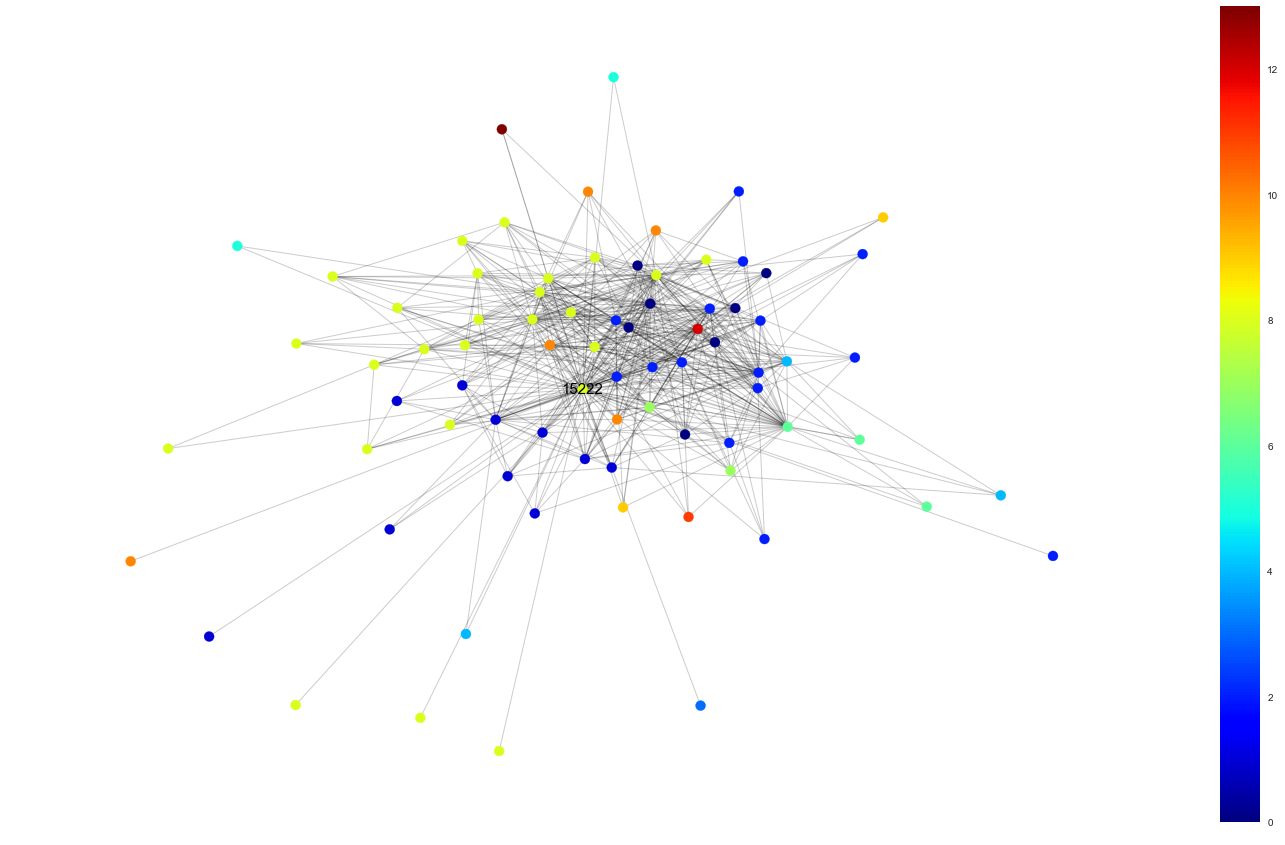

In [70]:
# get unique groups
zipcodes = set(nx.get_node_attributes(s_15222,'zip').values())
mapping = dict(zip(sorted(zipcodes),count()))
nodes = s_15222.nodes()
colors_zip = [mapping[s_15222.node[n]['zip']] for n in nodes]


label_seed = {'SsGNAc9U-aKPZccnaDtFkA': '15222'}

# drawing nodes and edges separately so we can capture collection for colorbar
ec = nx.draw_networkx_edges(s_15222, pos8, alpha=0.2)
nc = nx.draw_networkx_nodes(s_15222, pos8, nodelist=nodes, node_color=colors_zip, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet, node_shape = 'o')
lb=nx.draw_networkx_labels(s_15222, pos8, label_seed, font_size = 15, font_color = 'black')

plt.colorbar(nc, orientation = 'vertical')
plt.axis('off')
plt.show()

Although this restaurant is connected to a few in the same zip code, it is also connected to a bunch in various other zip code. We cannot conclude that restaurants are reviewed within zip code. 

#### Subgraph - Water Level 15

In [63]:
print(nx.info(bsub15))
print "Is connected?: " + str(nx.is_connected(bsub15))
print "Is bipartite?: " + str(nx.is_bipartite(bsub15))
print "Density: " + str(nx.density(bsub15))

Name: Business subgraph water level 15
Type: Graph
Number of nodes: 42
Number of edges: 74
Average degree:   3.5238
Is connected?: True
Is bipartite?: False
Density: 0.0859465737515


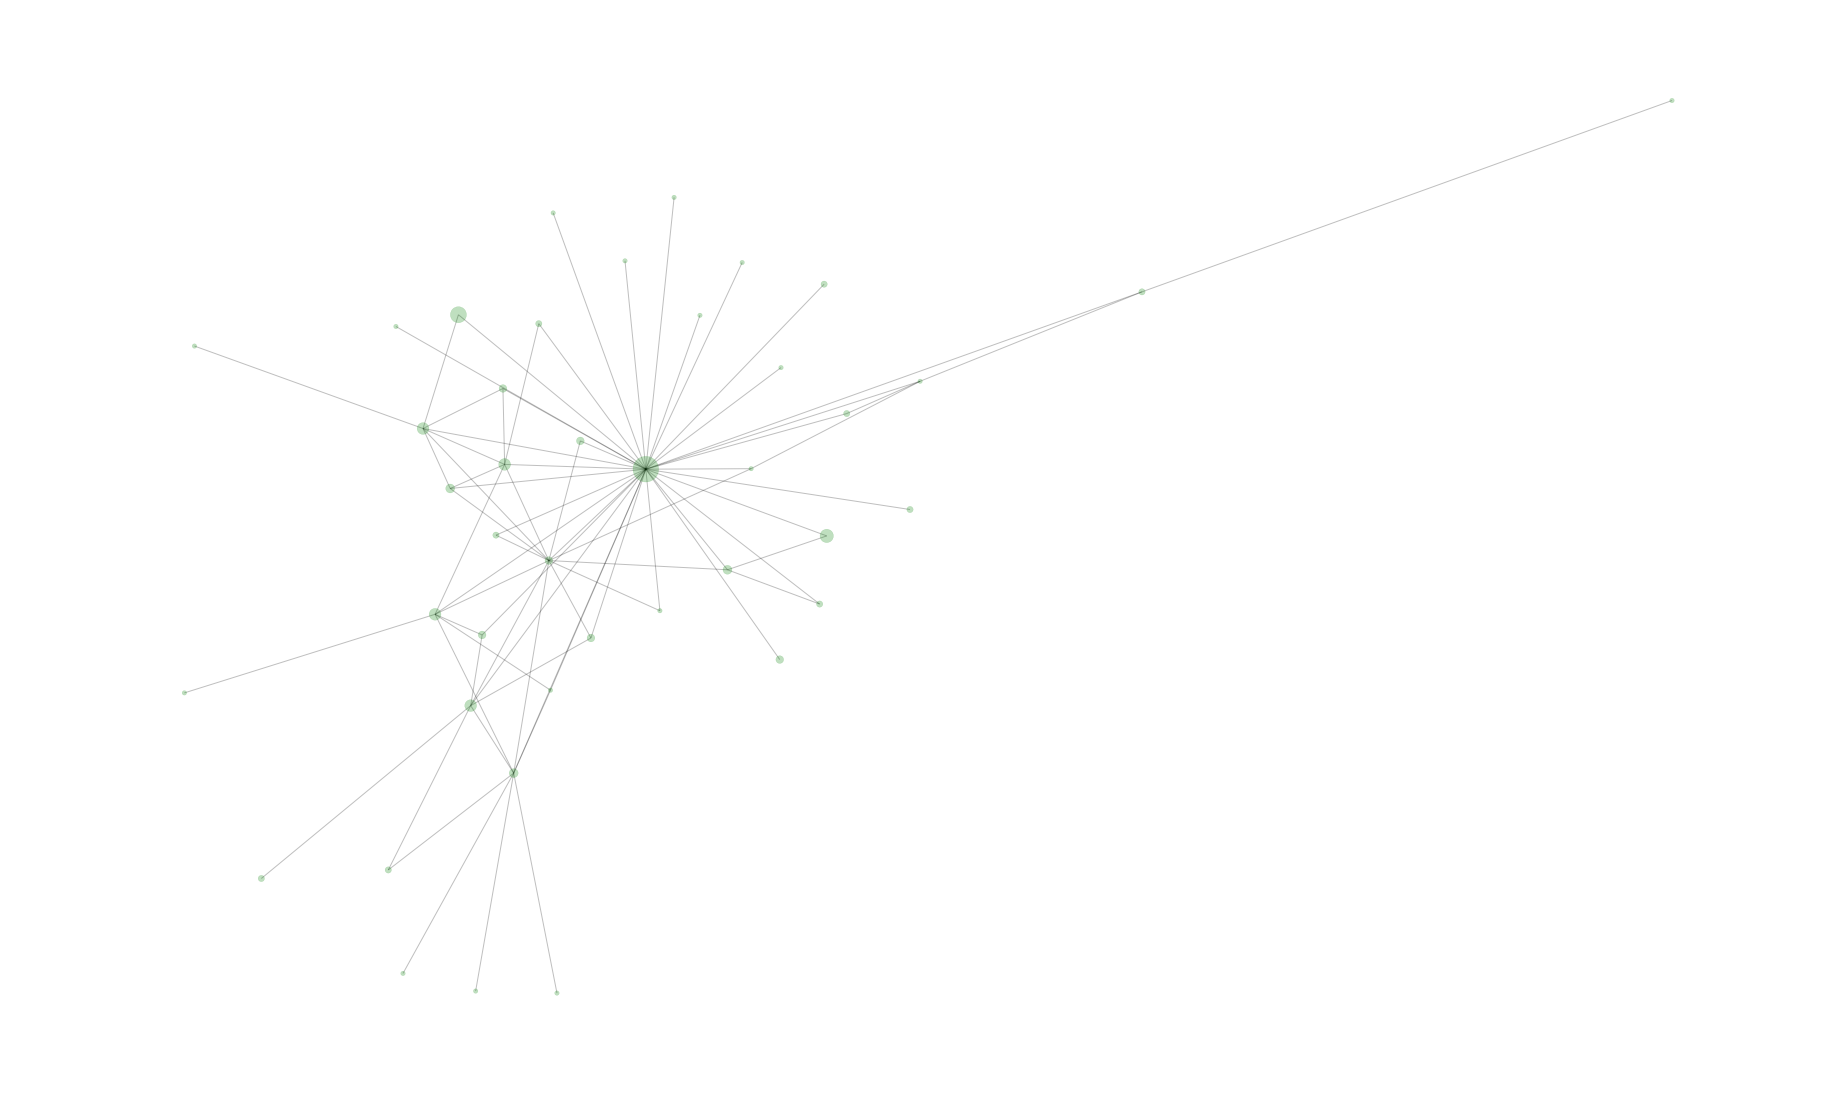

In [76]:
pos15 = nx.spring_layout(bsub15)
nx.draw(bsub15, pos15, node_size=[v*20 for v in bsub15.degree().values()], with_labels=False, node_color='g', alpha=.25, font_size=20)

We will first draw the graph and represent the weight of each edge. We will differenciate the edges based on weights. To do so, we will assign weight size and color in intervals of 5 (i.e. <= 9, 10-14, 15-19, 20-24, 25-29, 30-34, >= 35).  

In [81]:
e15_1=[(u,v) for (u,v,d) in bsub15.edges(data=True) if d['weight'] < 10]
e15_2=[(u,v) for (u,v,d) in bsub15.edges(data=True) if d['weight'] in range(10,15)]
e15_3=[(u,v) for (u,v,d) in bsub15.edges(data=True) if d['weight'] in range(15,20)]
e15_4=[(u,v) for (u,v,d) in bsub15.edges(data=True) if d['weight'] in range(20,25)]      
e15_5=[(u,v) for (u,v,d) in bsub15.edges(data=True) if d['weight'] in range(25,30)]
e15_6=[(u,v) for (u,v,d) in bsub15.edges(data=True) if d['weight'] in range(30,35)]
e15_7=[(u,v) for (u,v,d) in bsub15.edges(data=True) if d['weight'] >= 35]

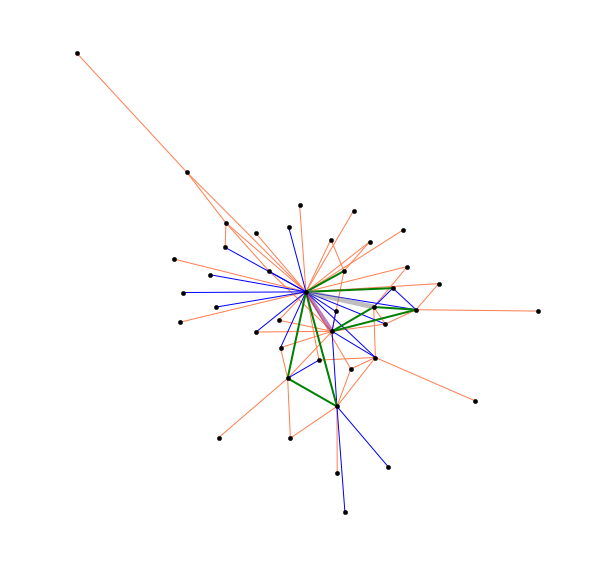

In [84]:
# Set the size of frame for drawing
plt.figure(figsize=(10,10))
plt.axis("off")

# Nodes Layout      
pos15 = nx.spring_layout(bsub15)

# nodes
nx.draw_networkx_nodes(bsub15,pos15,node_size=20, with_labels=False, node_color='black', alpha=1)

# edges
nx.draw_networkx_edges(bsub15,pos15,edgelist=e15_1,width=1, alpha=0.8, edge_color = 'gold')
nx.draw_networkx_edges(bsub15,pos15,edgelist=e15_2,width=1, alpha=0.8, edge_color = 'cyan')
nx.draw_networkx_edges(bsub15,pos15,edgelist=e15_3, width=1, alpha=1, edge_color = 'coral')
nx.draw_networkx_edges(bsub15,pos15,edgelist=e15_4, width=1, alpha=1, edge_color = 'blue')
nx.draw_networkx_edges(bsub15,pos15,edgelist=e15_5, width=2, alpha=1, edge_color = 'green')
nx.draw_networkx_edges(bsub15,pos15,edgelist=e15_6, width=4, alpha=0.5, edge_color = 'purple')
nx.draw_networkx_edges(bsub15,pos15,edgelist=e15_7, width=5, alpha=0.5, edge_color = 'grey')

From this graph, we can see that we have 2 distinct edges with the highest weights. We also have a node which is very central to the graph.  

We will look at centrality measures next.

#### Centrality Measures

In [92]:
# Centrality Measures
bsub15_deg = nx.degree_centrality(bsub15)

ds_deg15=sorted_map(bsub15_deg)

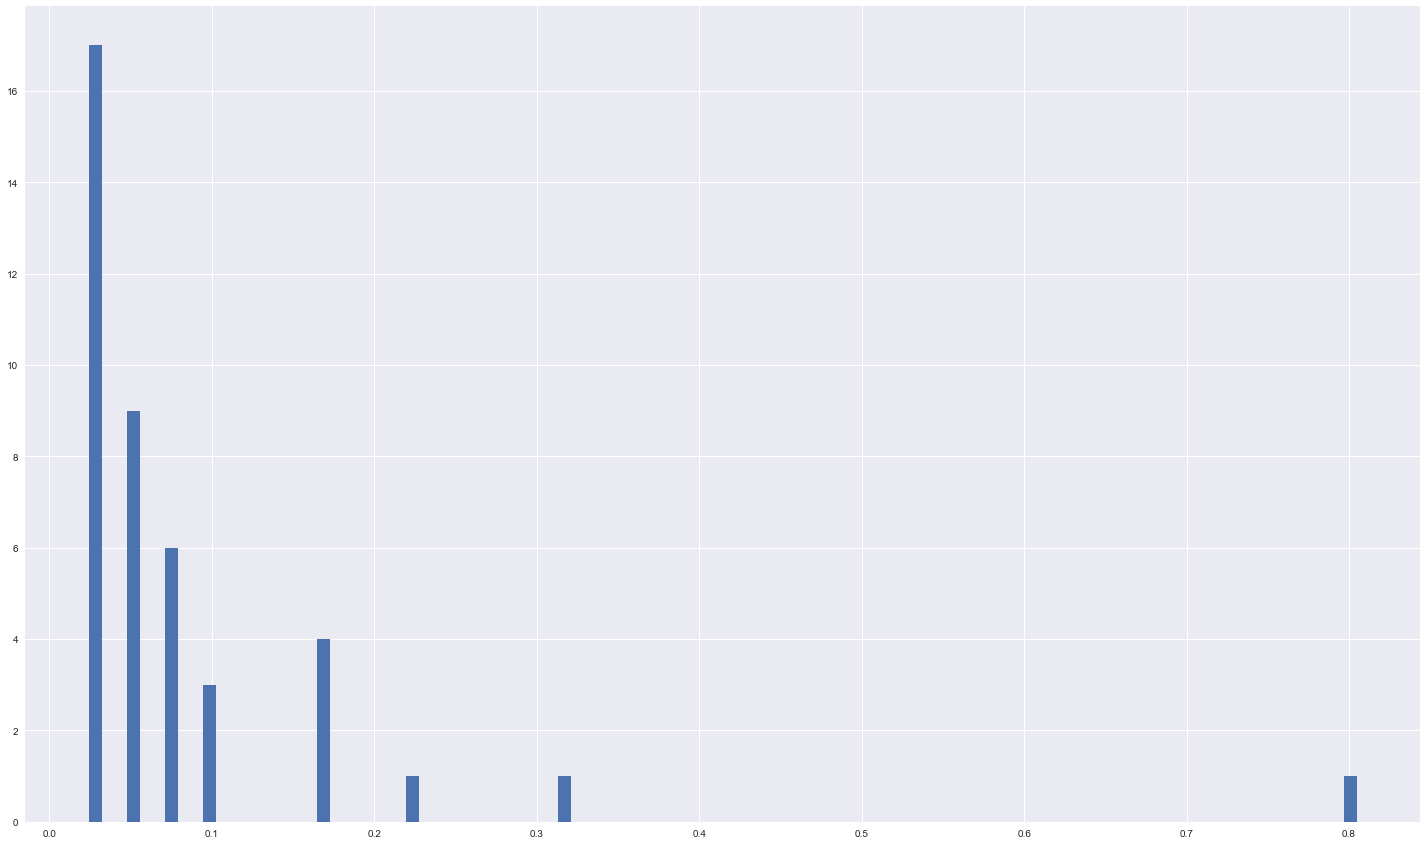

In [93]:
h=plt.hist(bsub15_deg.values(), 100)

In [102]:
# Closeness Centrality
bsub15_clos = nx.closeness_centrality(bsub15)

ds_clos15=sorted_map(bsub15_clos)

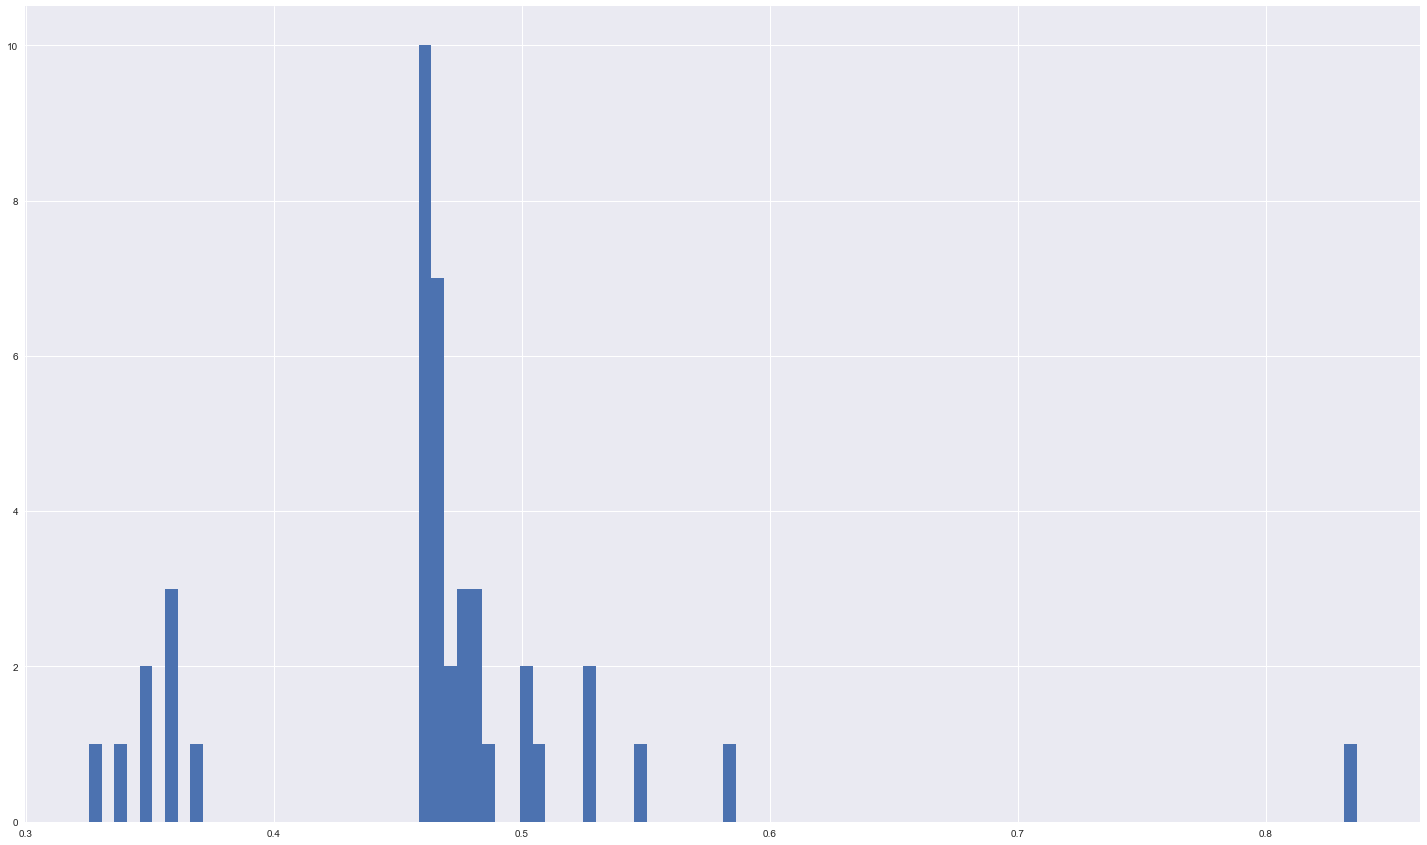

In [95]:
h=plt.hist(bsub15_clos.values(), 100)

In [96]:
## Betweeness Centrality
bsub15_bet = nx.betweenness_centrality(bsub15)

ds_bet15=sorted_map(bsub15_bet)

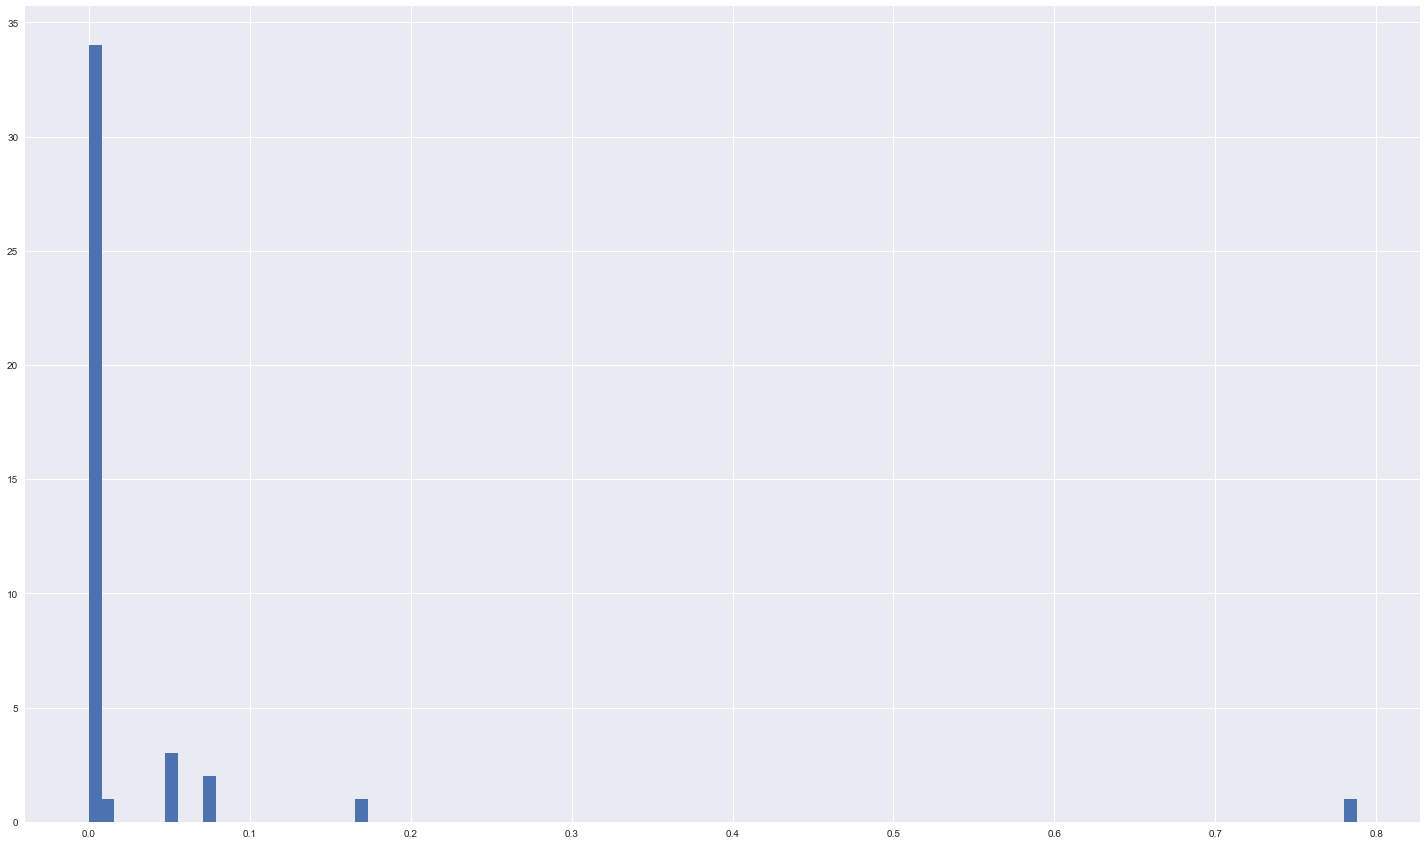

In [97]:
h=plt.hist(bsub15_bet.values(), 100)

In [98]:
## Eigenvector Centrality
bsub15_eig = nx.eigenvector_centrality(bsub15)

ds_eig15=sorted_map(bsub15_eig)


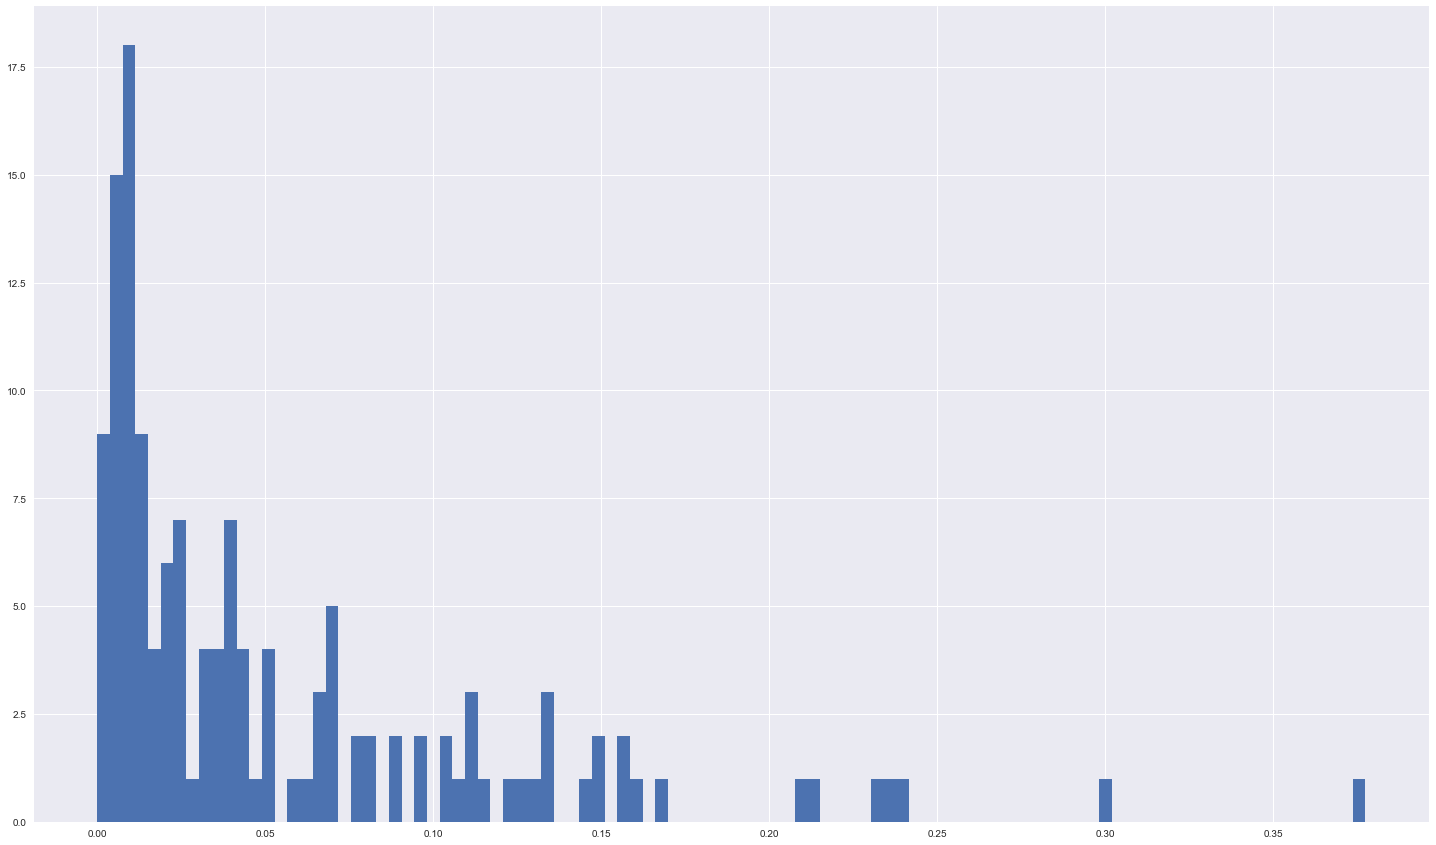

In [51]:
h=plt.hist(bsub15_eig.values(), 100)

In this graph, it is clear that we have a node which is central to it.  We will identify this node by looking at the top element of each sorted centrality measures. 


In [99]:
ds_deg15[0]

('SsGNAc9U-aKPZccnaDtFkA', 0.8048780487804879)

In [103]:
ds_clos15[0]

('SsGNAc9U-aKPZccnaDtFkA', 0.8367346938775511)

In [104]:
ds_bet15[0]

('SsGNAc9U-aKPZccnaDtFkA', 0.7880894308943089)

In [105]:
ds_eig15[0]

('SsGNAc9U-aKPZccnaDtFkA', 0.5706495141861108)

Not surprising, we have the same node, we can identify it from the business date frame to confirm that this node is indeed: "Meat & Potatoes".  

In [106]:
print str(df_bsub8_atr.loc['SsGNAc9U-aKPZccnaDtFkA'])

name                                                Meat & Potatoes
full_address       649 Penn Ave\r\nDowntown\r\nPittsburgh, PA 15222
categories         c("Gastropubs", "American (New)", "Restaurants")
city                                                     Pittsburgh
state                                                            PA
review_count                                                    657
neighborhoods                                              Downtown
unique_category                                      American (New)
zip_code                                                      15222
Name: SsGNAc9U-aKPZccnaDtFkA, dtype: object


We will print the graph identifying the zip code of each node in the graph.

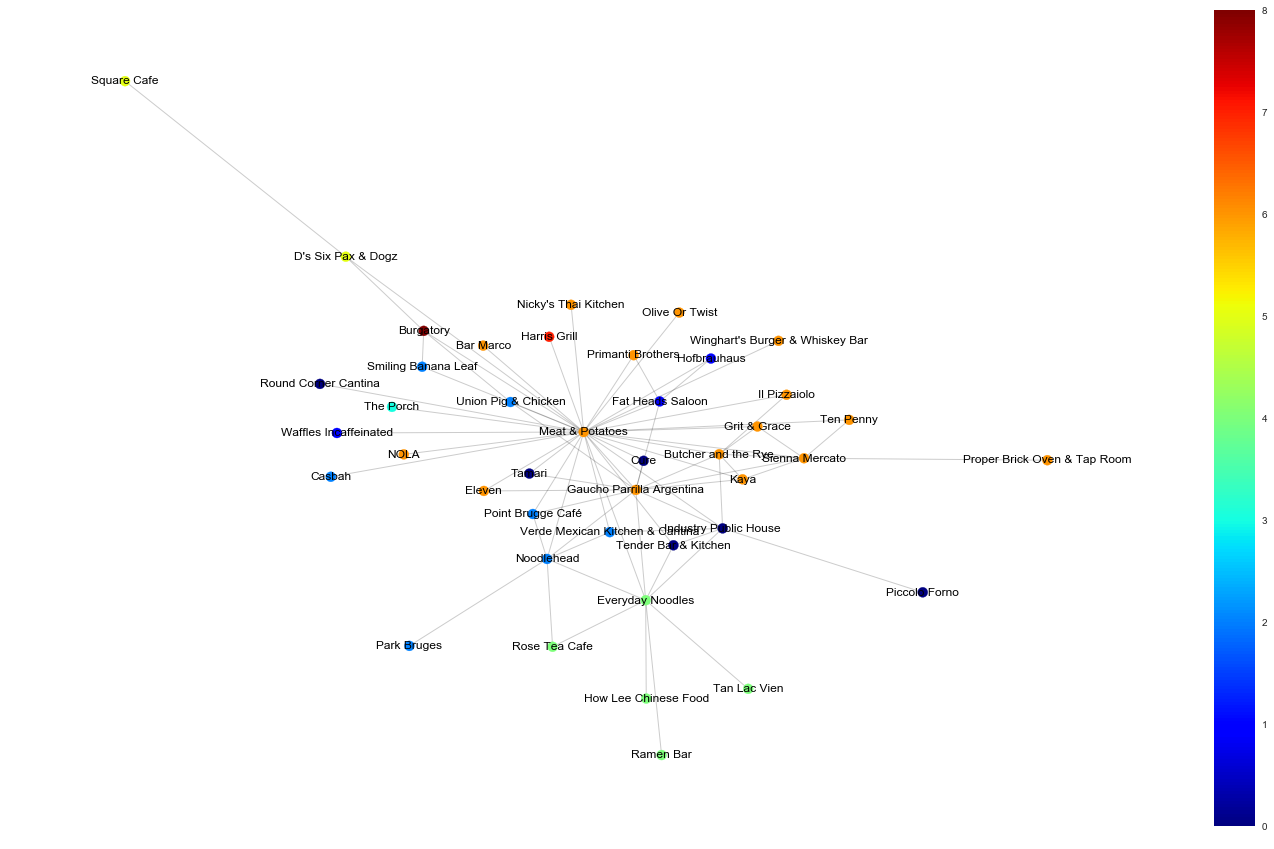

In [109]:
# get unique groups
zipcodes = set(nx.get_node_attributes(bsub15,'zip').values())
mapping = dict(zip(sorted(zipcodes),count()))
nodes = bsub15.nodes()
colors_zip = [mapping[bsub15.node[n]['zip']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colorbar
ec = nx.draw_networkx_edges(bsub15, pos15, alpha=0.2)
nc = nx.draw_networkx_nodes(bsub15, pos15, nodelist=nodes, node_color=colors_zip, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)

labels = nx.get_node_attributes(bsub15,'name')
lb=nx.draw_networkx_labels(bsub15, pos15, labels, font_size = 12, font_color = 'black')

plt.colorbar(nc, orientation = 'vertical')
plt.axis('off')
plt.show()

Based on this analysis there does not seem to be any correlation betwen the restaurant location whether it will be associated (via review) with other restaurants in the same location.  Nor is there apparent relation with the type of restaurant and whether it will be associated with similar type.  

Further analysis would be necessary to understand whether there are some patterns to wich restaurants are associated together.  Possibly we would need additional attribute such as average cost of meal or some other data element.  

Also, the next set of analysis may be done at the triad levels.
